In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

In [3]:
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

In [4]:
metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]    

In [5]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    return "GALAXY" if "GALAXY" in val else "OTHER"

In [7]:
with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]    

In [8]:
labels_simplified = pd.Series(labels).apply(simplify_targettype).values
galaxy_mask = labels_simplified == "GALAXY"

valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)

final_mask = galaxy_mask & valid_indices

In [9]:
filters = ["u", "g", "r", "i", "z"]

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
   
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

In [10]:
all_images = all_images[:][0]

In [22]:
def measure_object_size_with_two_thresholds(
    img, 
    hard_fraction=0.7,  # более жёсткий порог для нахождения «ядра»
    soft_fraction=0.3,  # более мягкий порог для общей формы
    min_size=5
):
    """
    Возвращает:
      - (cy, cx): координаты центра (ядра) объекта (None, None если не найдено)
      - max_dist: максимальное расстояние от (cy, cx) до края объекта
    Пояснения:
      1) Сначала ищем яркий центр, используя hard_fraction * max(img).
      2) Потом создаём более мягкую маску через soft_fraction * max(img).
      3) Находим среди связных компонент ту, которая содержит (cy, cx).
      4) Если такая компонента найдена, считаем max_dist.
    min_size: минимальное число пикселей, чтобы считать компоненту валидной.
    """
    # 1) HARD threshold mask -> find bright center
    max_val = np.max(img)
    if max_val <= 0:
        return (None, None), 0.0
    
    hard_thr = hard_fraction * max_val
    hard_mask = (img > hard_thr)
    
    cy, cx = ndimage.center_of_mass(hard_mask)
    if np.isnan(cy) or np.isnan(cx):
        # не нашли яркий центр
        return (None, None), 0.0
    
    # 2) SOFT threshold mask -> for the whole shape
    soft_thr = soft_fraction * max_val
    soft_mask = (img > soft_thr)
    
    # 3) Label connected components in soft_mask
    labeled, num_labels = ndimage.label(soft_mask)
    if num_labels == 0:
        return (None, None), 0.0
    
    # Определяем, какой ярлык (label) содержит пиксель (cy, cx).
    # Округлим координаты до целых (row,col).
    row_center = int(round(cy))
    col_center = int(round(cx))
    if (row_center < 0 or row_center >= img.shape[0] or
        col_center < 0 or col_center >= img.shape[1]):
        return (None, None), 0.0
    
    label_of_center = labeled[row_center, col_center]
    if label_of_center == 0:
        # «яркий центр» лежит вне связных компонент soft_mask -> значит, не найдено
        return (None, None), 0.0
    
    # 4) Extract coordinates of that component
    coords = np.column_stack(np.where(labeled == label_of_center))
    if len(coords) < min_size:
        # слишком маленькая компонента
        return (None, None), 0.0
    
    # считаем расстояние от (cy, cx) до каждого пикселя этой компоненты
    dist = np.sqrt((coords[:, 0] - cy)**2 + (coords[:, 1] - cx)**2)
    max_dist = dist.max() if len(dist) > 0 else 0.0
    
    return (cy, cx), max_dist

def visualize_two_thresholds(img, hard_fraction=0.7, soft_fraction=0.3):
    """
    Пример визуализации для одного изображения:
      - показывает исходное изображение
      - рисует круг с радиусом max_dist
      - рисует красный плюс в месте яркого центра
      - пунктирную линию до самой дальней точки
    """
    (cy, cx), max_dist = measure_object_size_with_two_thresholds(
        img, hard_fraction=hard_fraction, soft_fraction=soft_fraction
    )
    
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap="viridis", origin="upper")
    if cy is not None and cx is not None:
        # рисуем круг
        circ = plt.Circle((cx, cy), radius=max_dist, color='red', fill=False, lw=2)
        plt.gca().add_patch(circ)
        
        # находим самую далёкую точку
        max_val = np.max(img)
        soft_thr = soft_fraction * max_val
        soft_mask = (img > soft_thr)
        labeled, _ = ndimage.label(soft_mask)
        
        row_center = int(round(cy))
        col_center = int(round(cx))
        label_of_center = labeled[row_center, col_center]
        
        coords = np.column_stack(np.where(labeled == label_of_center))
        dist = np.sqrt((coords[:, 0] - cy)**2 + (coords[:, 1] - cx)**2)
        idx_max = np.argmax(dist)
        far_y, far_x = coords[idx_max]
        
        # рисуем пунктирную линию
        plt.plot([cx, far_x], [cy, far_y], 'r--', lw=1.5)
        
        # отмечаем центр
        plt.plot(cx, cy, 'r+', markersize=8, mew=2)
    
    plt.title(f"Hard thr={hard_fraction}, Soft thr={soft_fraction}, MaxDist={max_dist:.2f}")
    plt.axis("off")
    plt.show()


#########################################
# ПРИМЕР ИСПОЛЬЗОВАНИЯ ДЛЯ ALL_IMAGES
#########################################
def analyze_images_with_two_thresholds(all_images, filters=None, hard_fraction=0.7, soft_fraction=0.3):
    """
    Обходит все изображения (num_images, num_filters, H, W),
    находит (cy, cx) и max_dist по алгоритму двух порогов.
    Возвращает массив shape (num_images, num_filters), где лежат max_dist.
    """
    num_images, num_filters, H, W = all_images.shape
    if filters is None:
        filters = [f"Filter {i}" for i in range(num_filters)]
    
    results = np.zeros((num_images, num_filters), dtype=np.float32)
    
    for i in range(num_images):
        for f in range(num_filters):
            img = all_images[i, f]
            _, max_dist = measure_object_size_with_two_thresholds(
                img, hard_fraction=hard_fraction, soft_fraction=soft_fraction
            )
            results[i, f] = max_dist
    
    # Пример вывода статистики
    for f in range(num_filters):
        dist_f = results[:, f]
        print(f"{filters[f]}: mean={dist_f.mean():.2f}, std={dist_f.std():.2f}, min={dist_f.min():.2f}, max={dist_f.max():.2f}")
    
    return results

In [23]:
max_distances = analyze_all_images(all_images, threshold_fraction=0.3, filters=filters)

Summary statistics of maximum distances:
u: mean=10.70, std=14.90, min=0.00, max=56.80
g: mean=5.68, std=9.44, min=0.00, max=52.33
r: mean=5.54, std=9.31, min=0.00, max=55.07
i: mean=4.45, std=7.23, min=0.00, max=63.66
z: mean=4.38, std=7.34, min=0.00, max=65.76


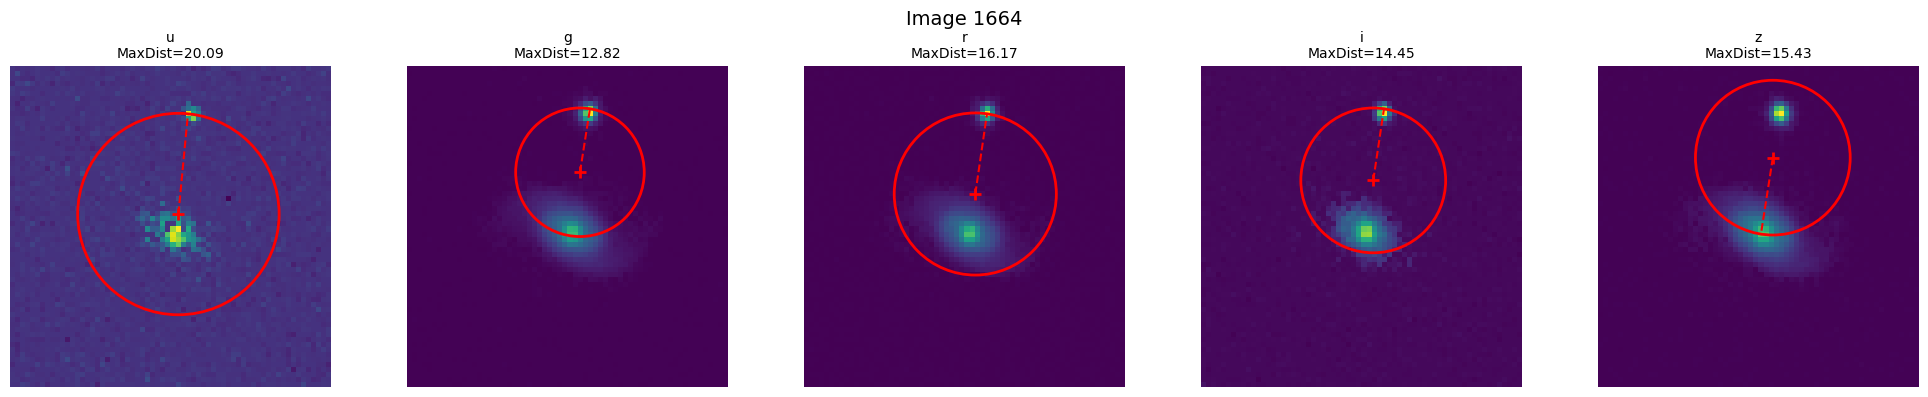

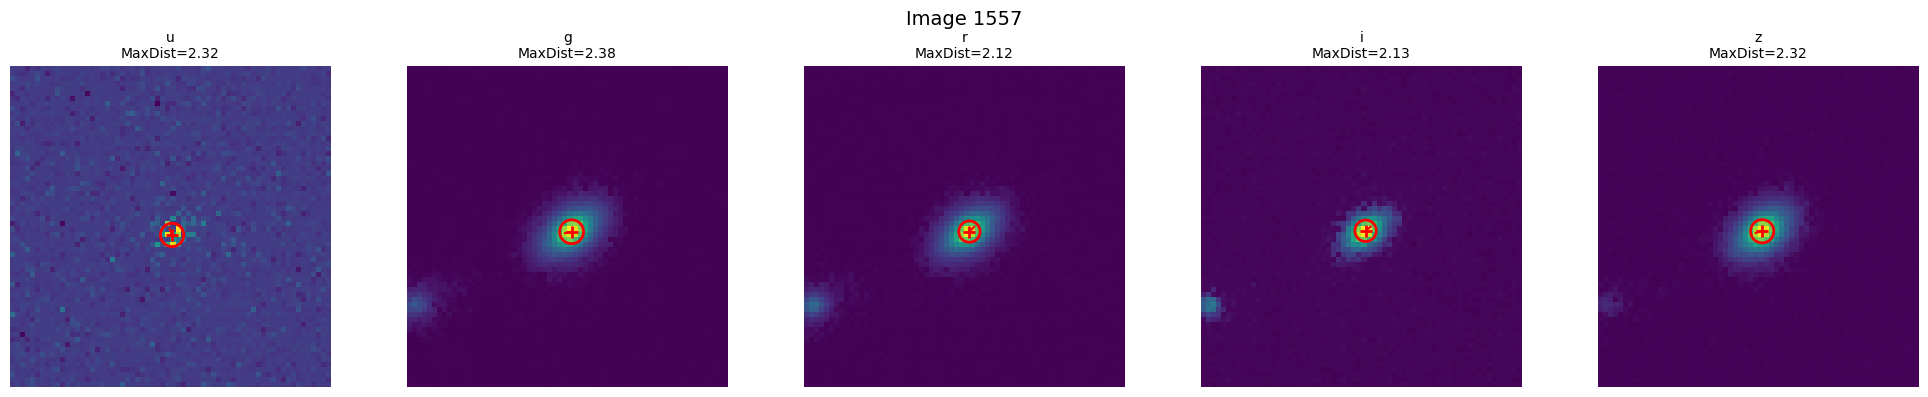

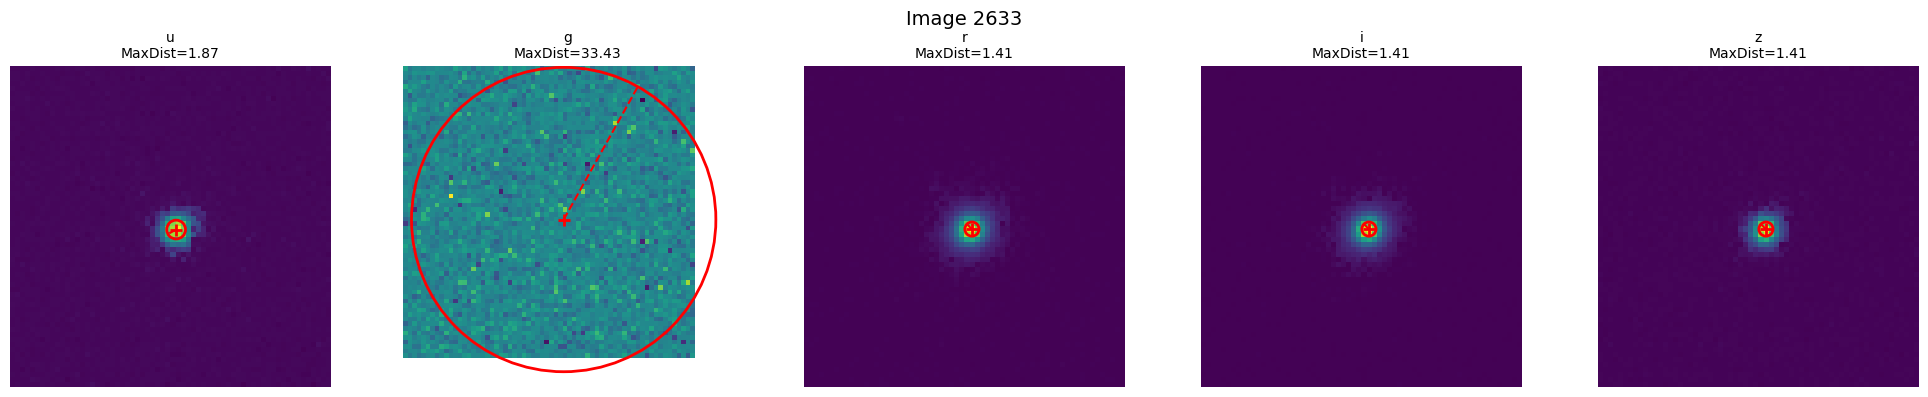

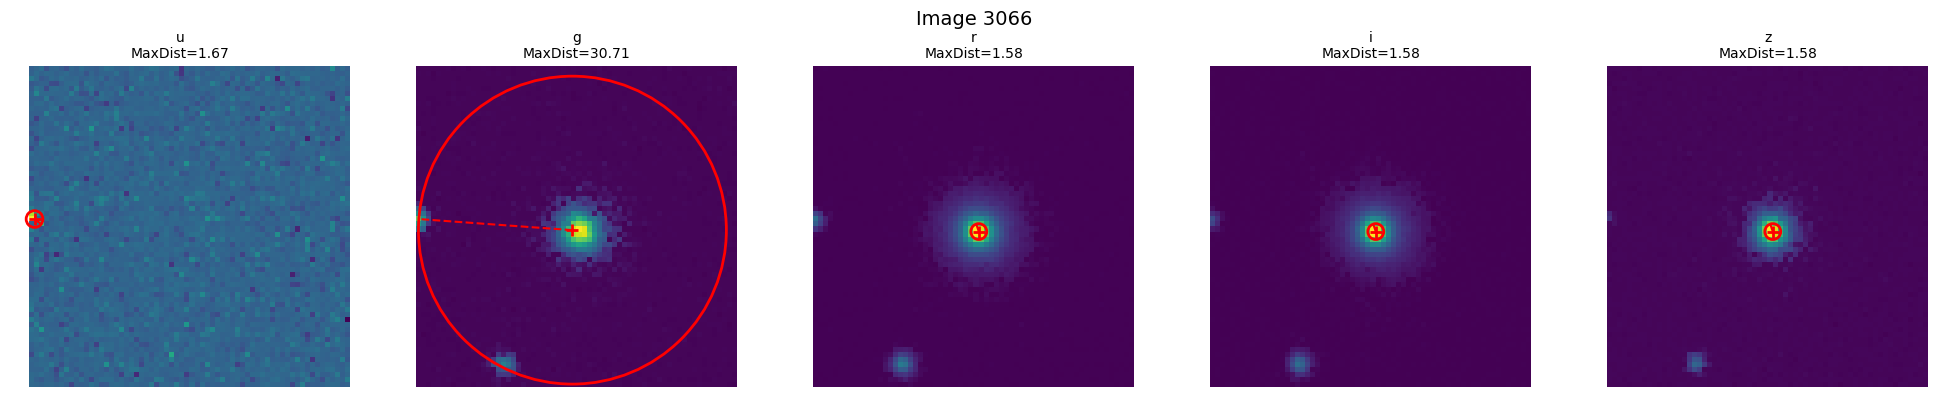

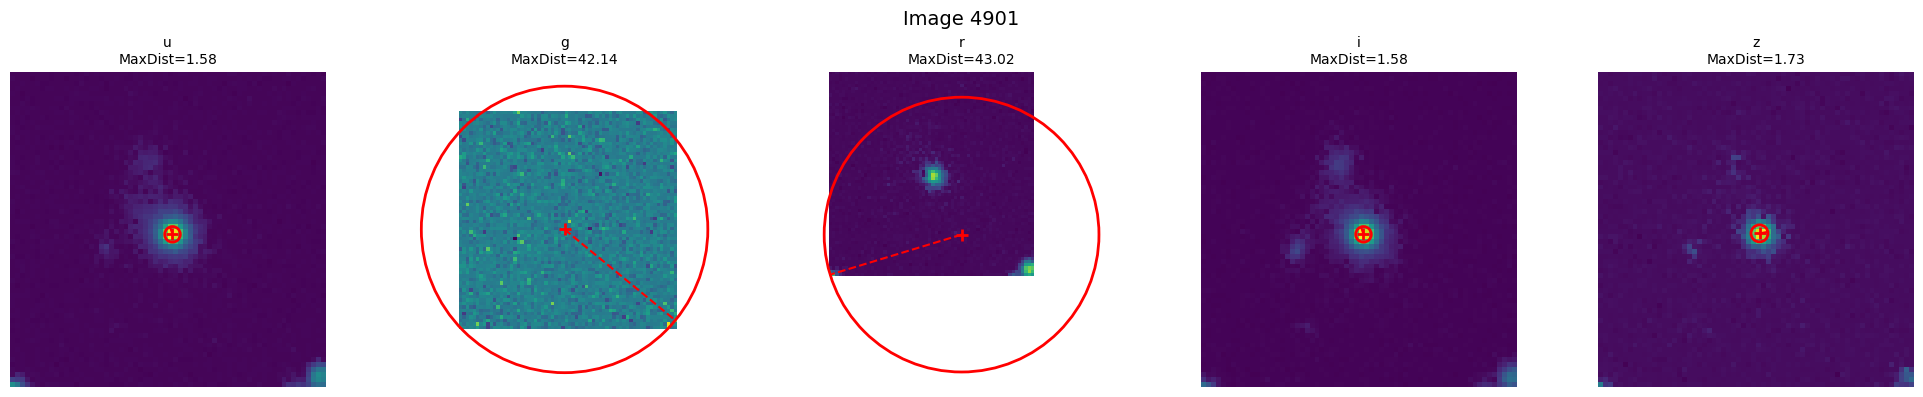

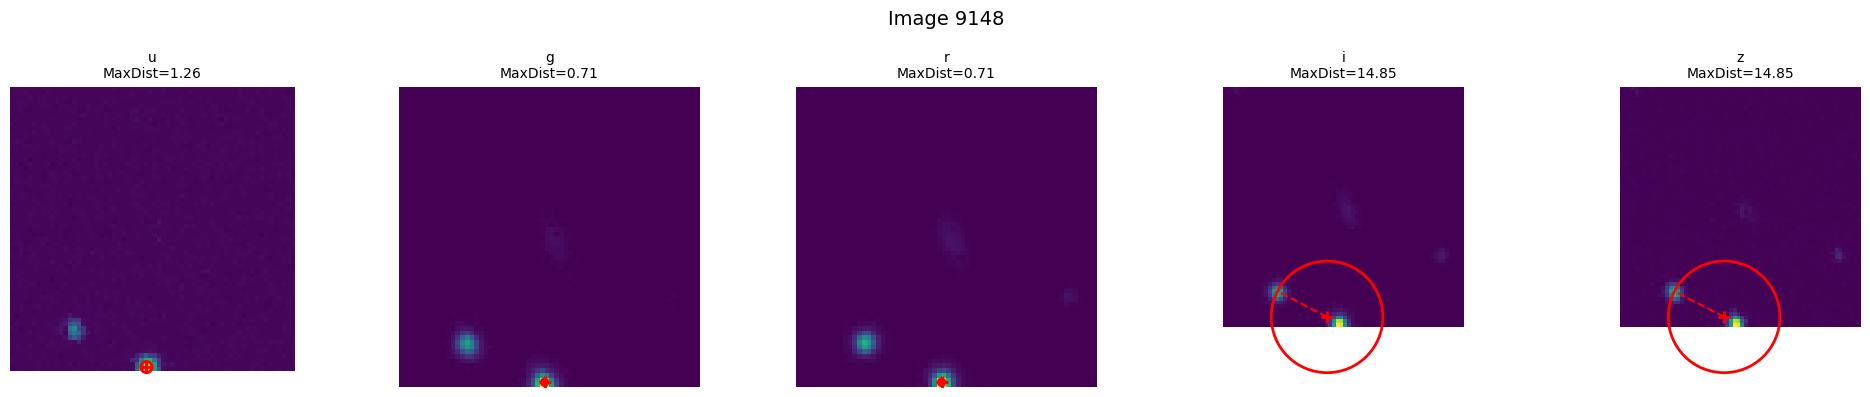

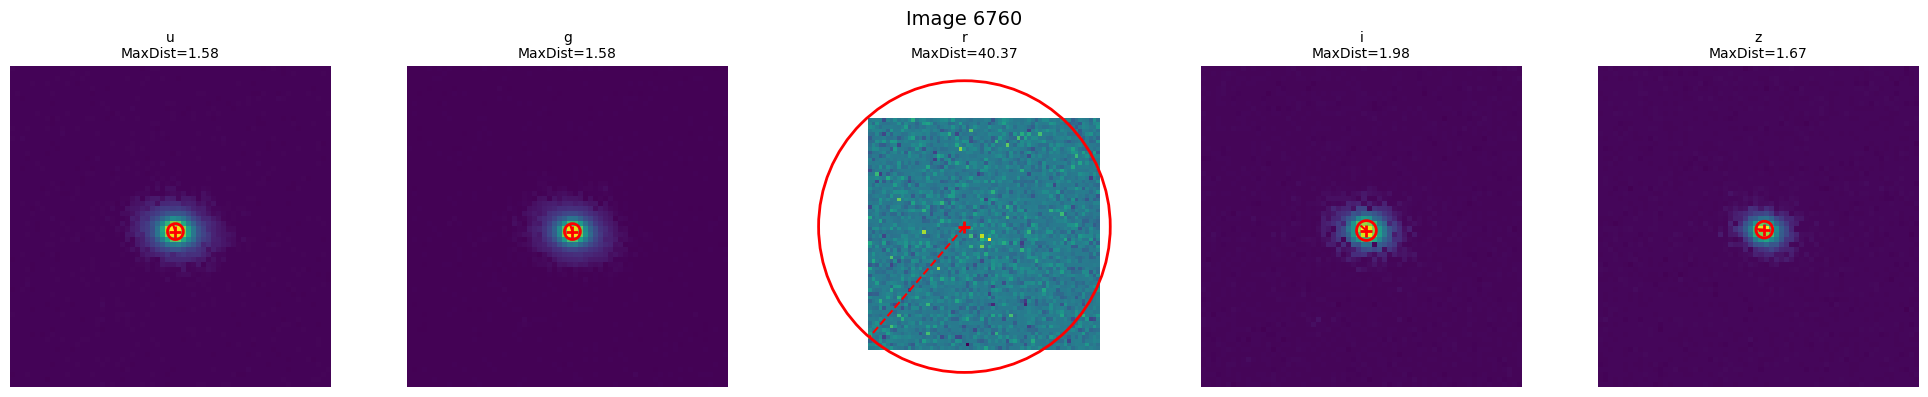

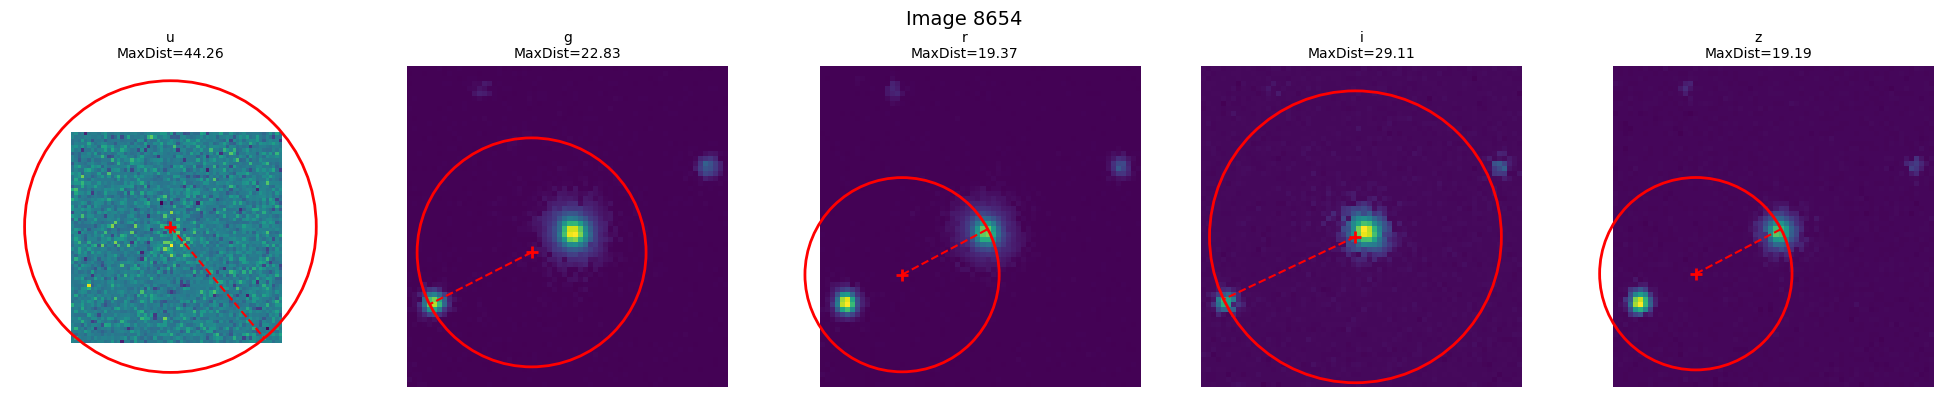

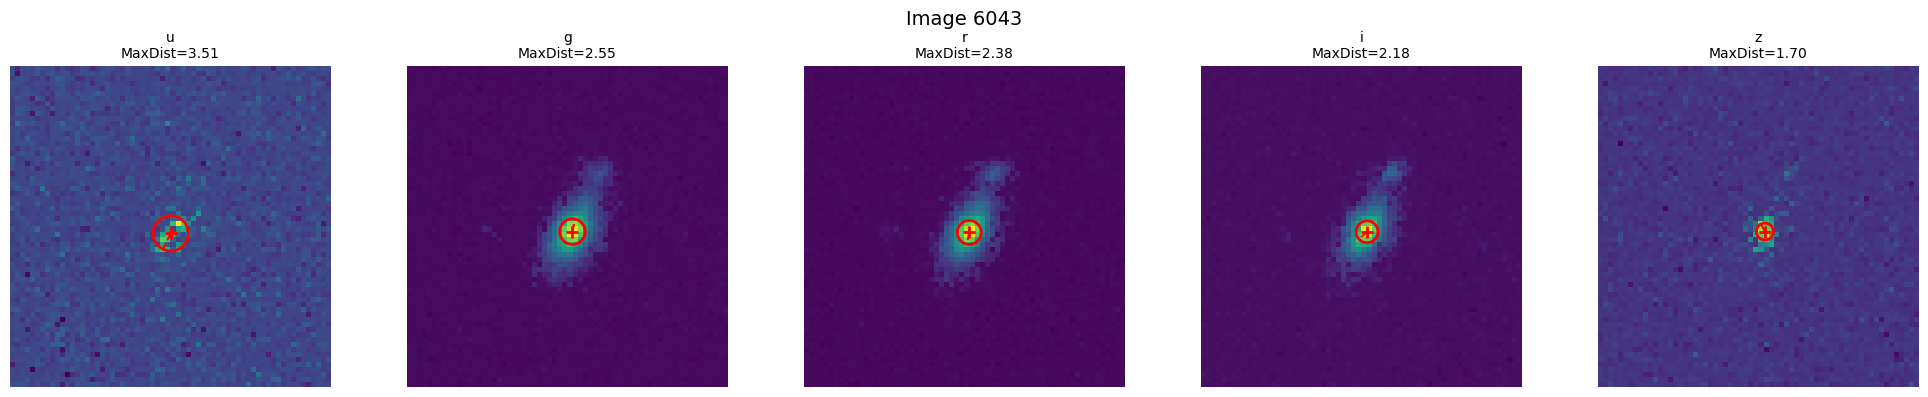

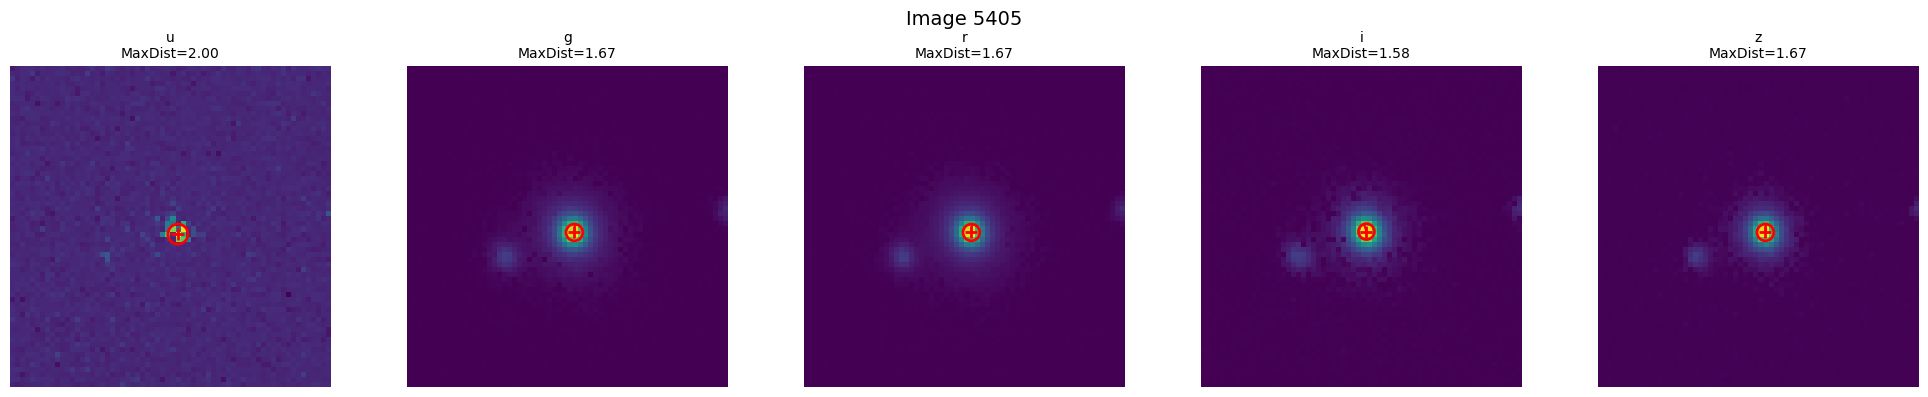

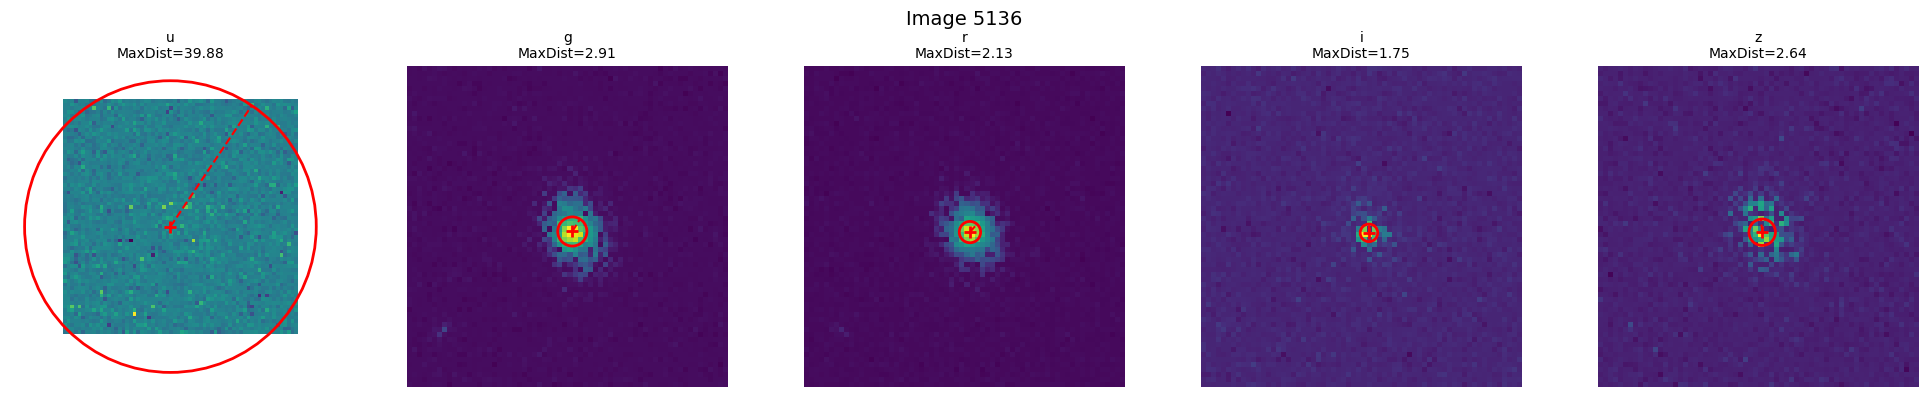

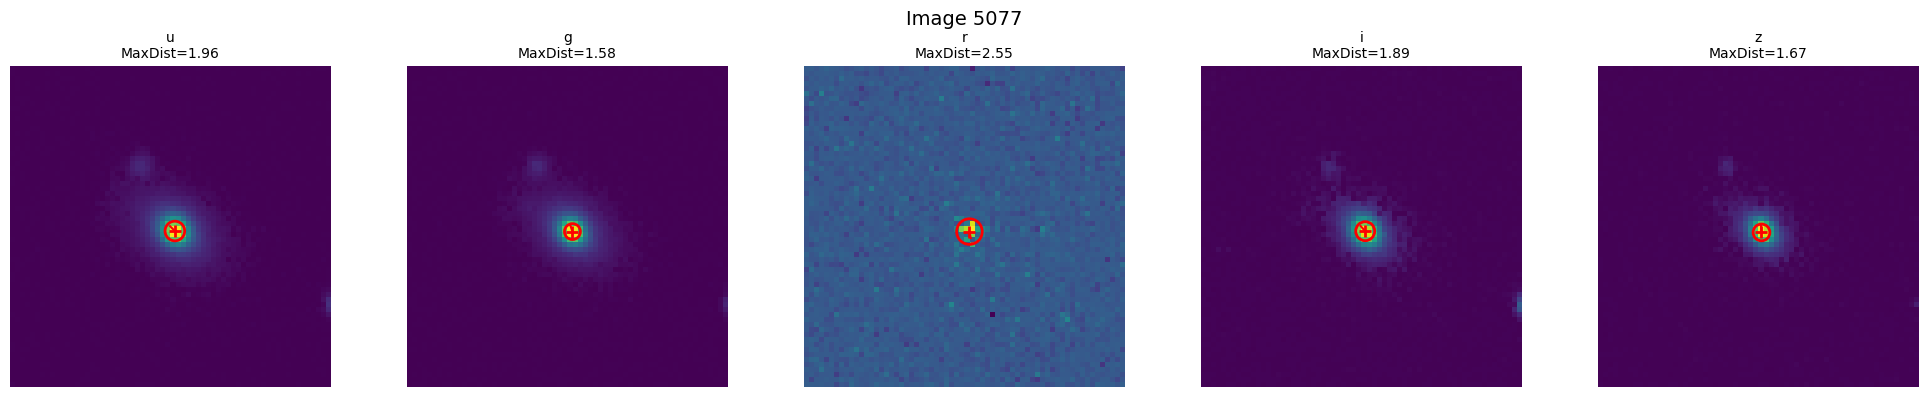

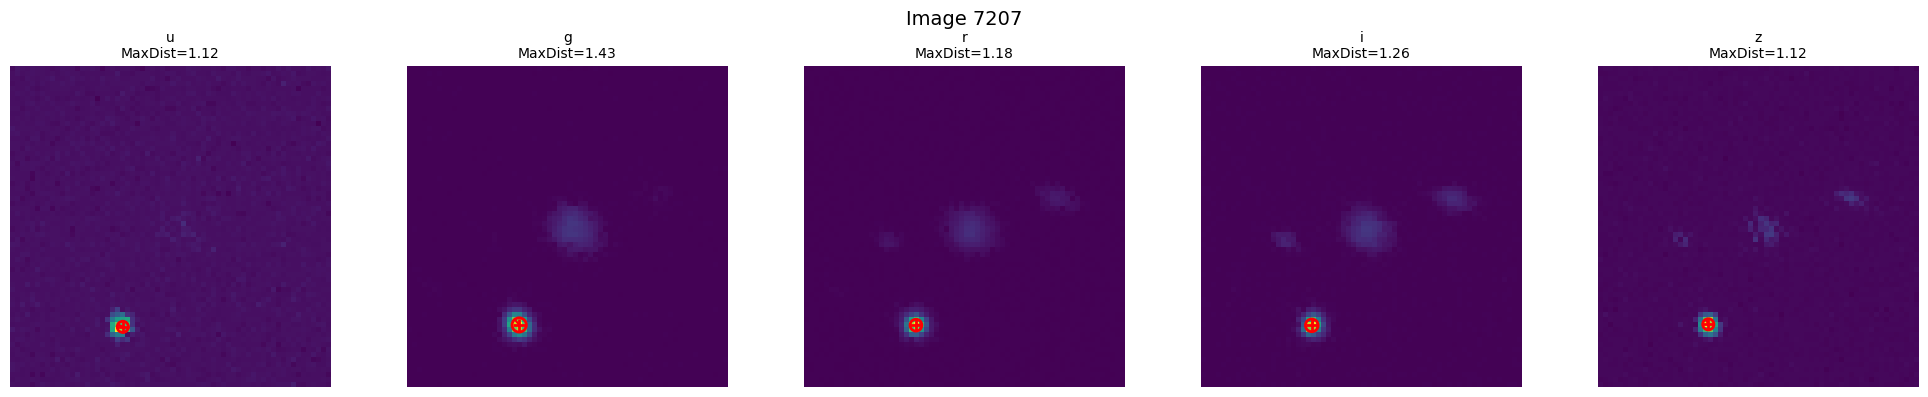

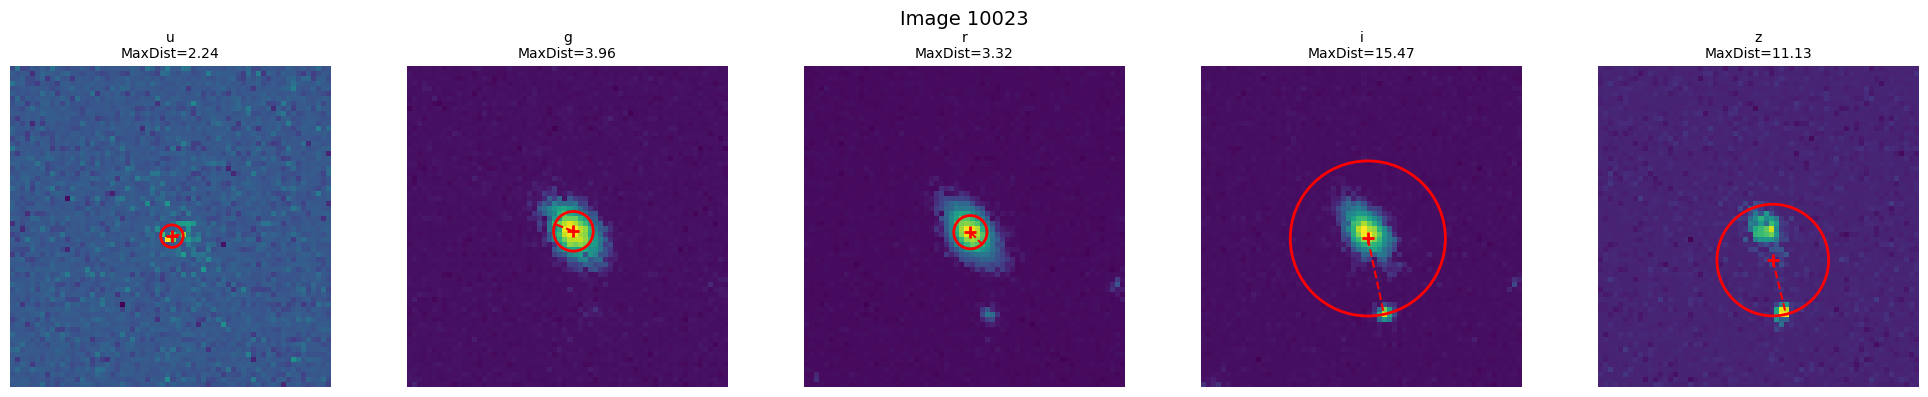

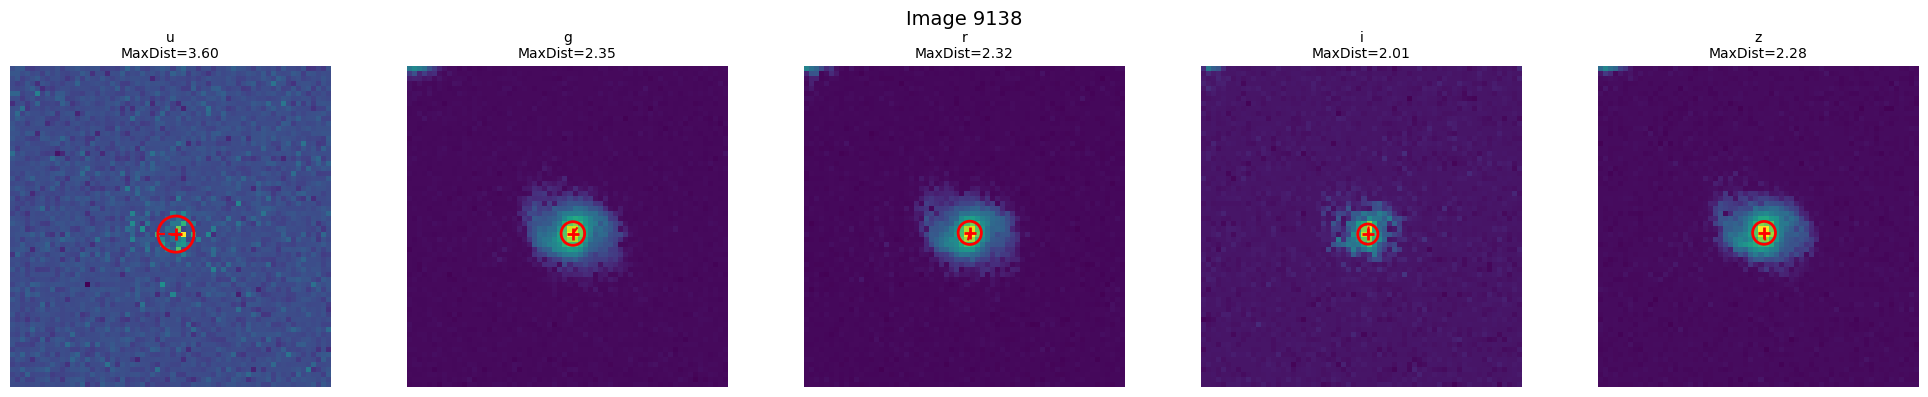

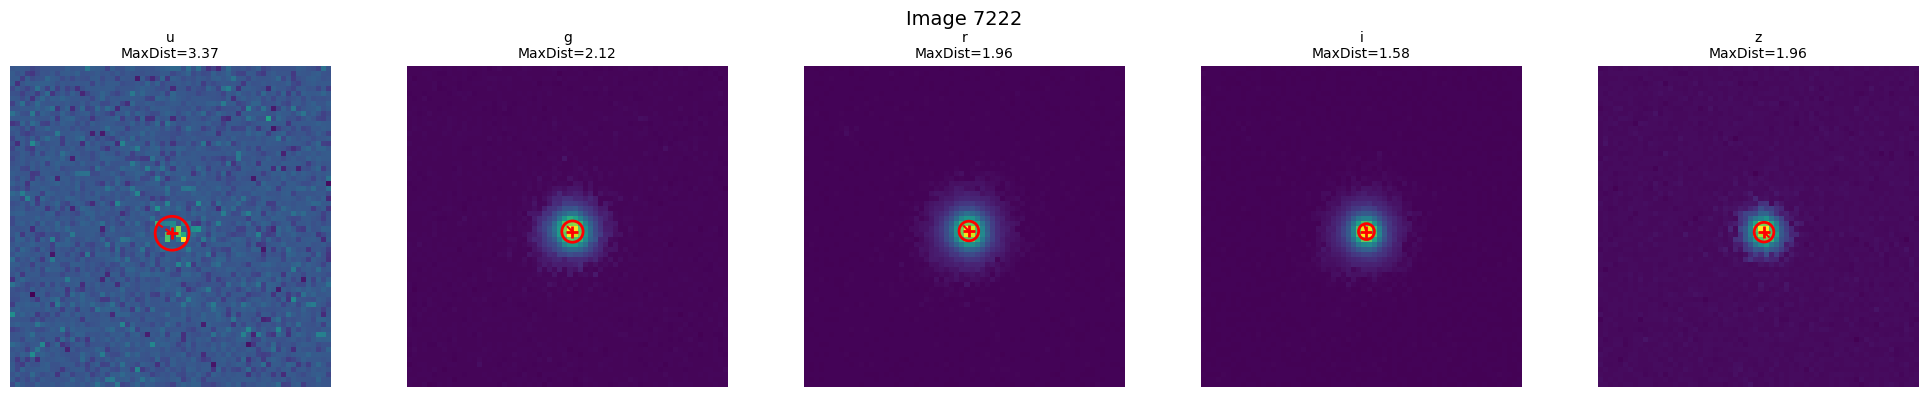

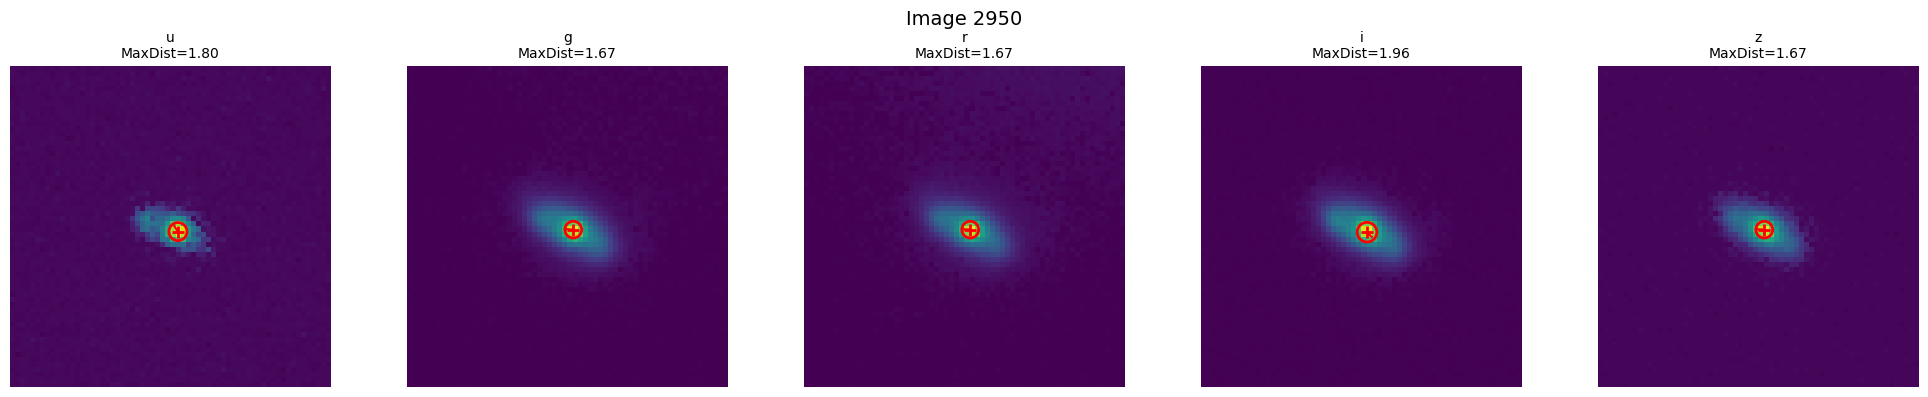

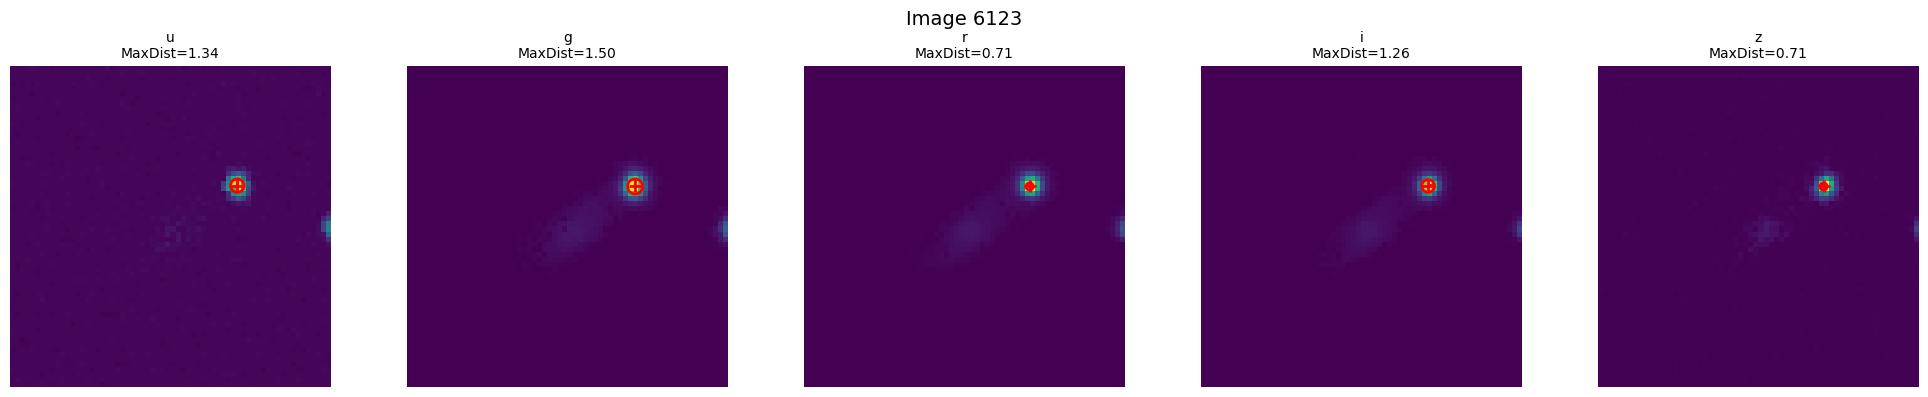

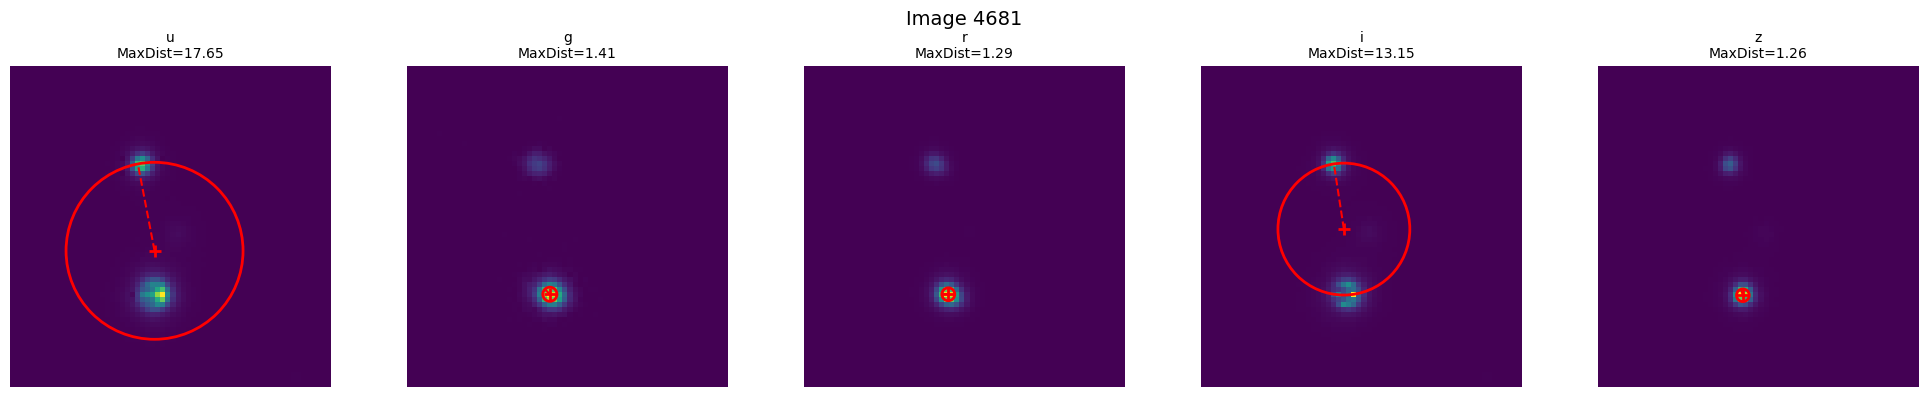

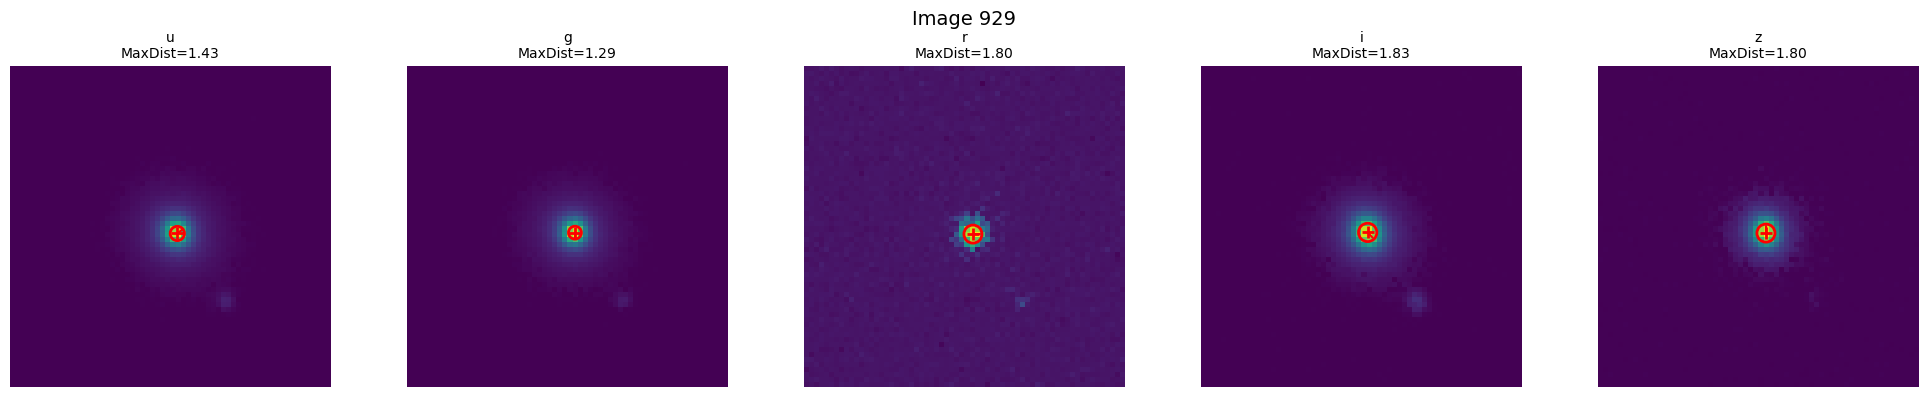

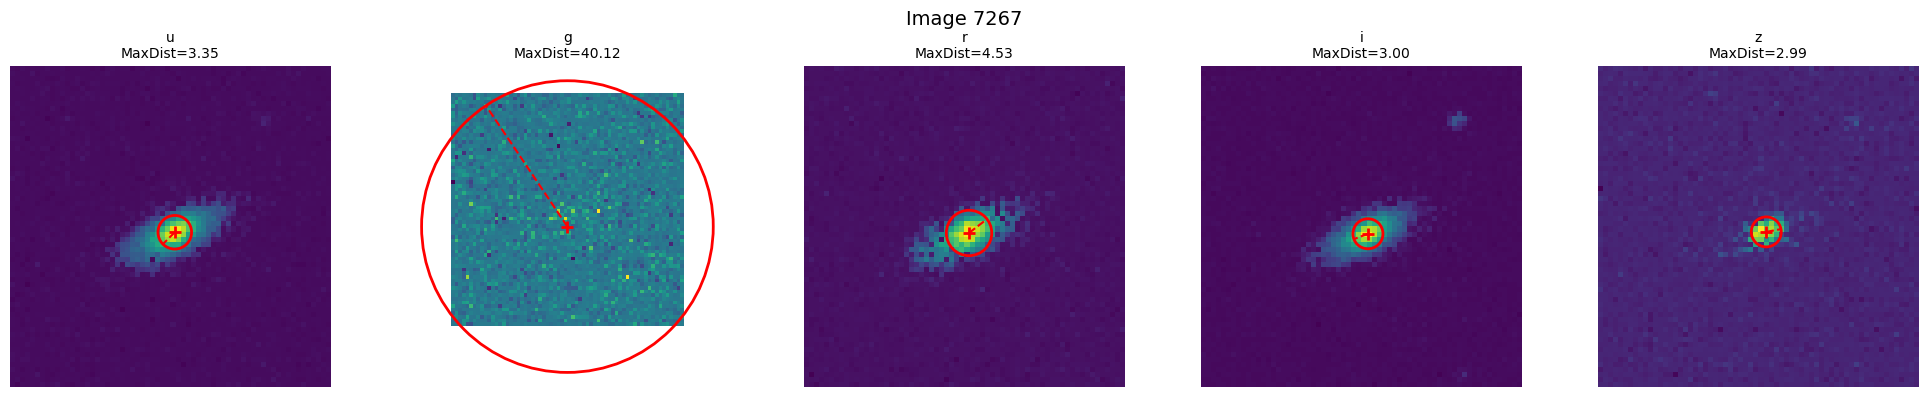

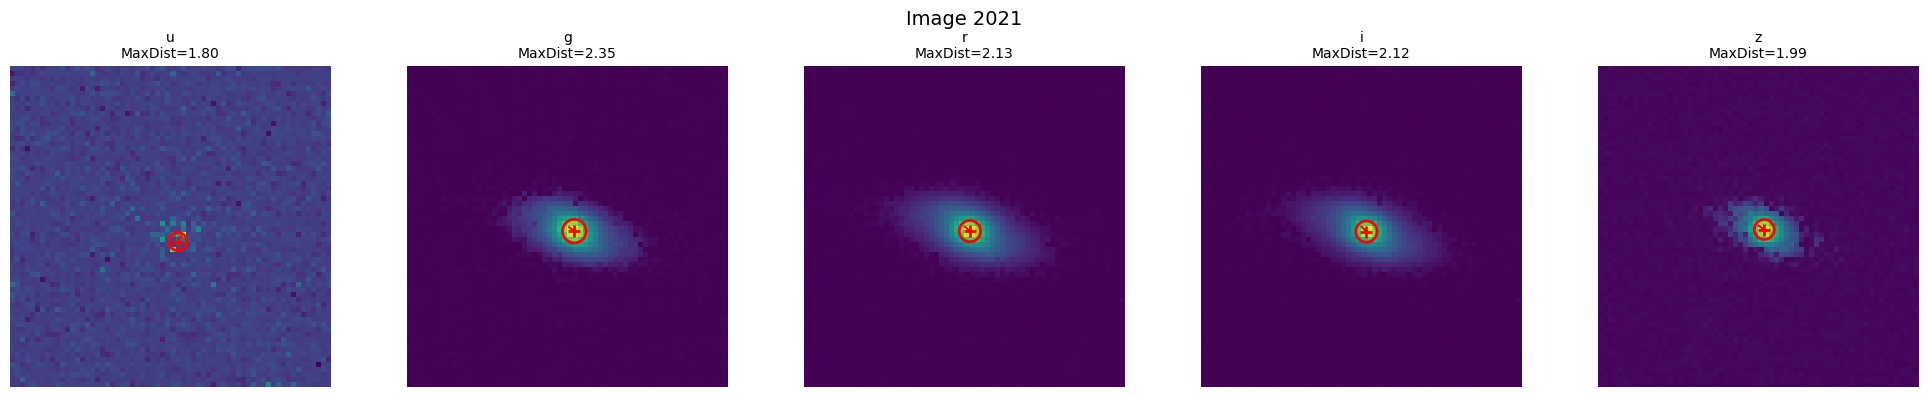

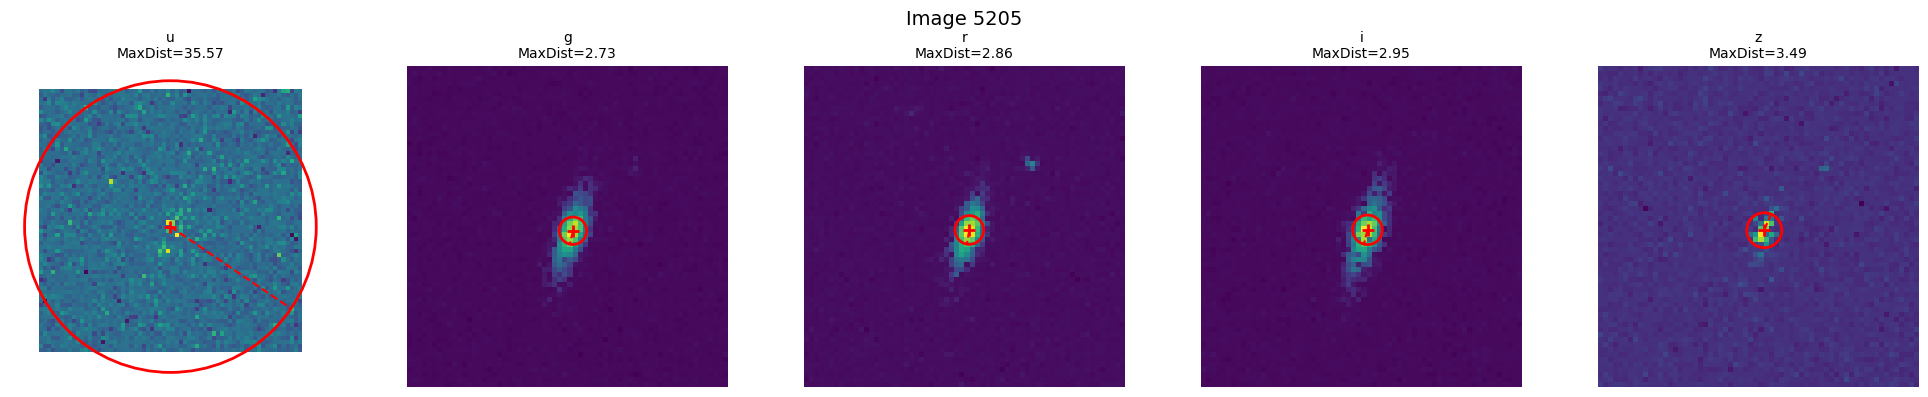

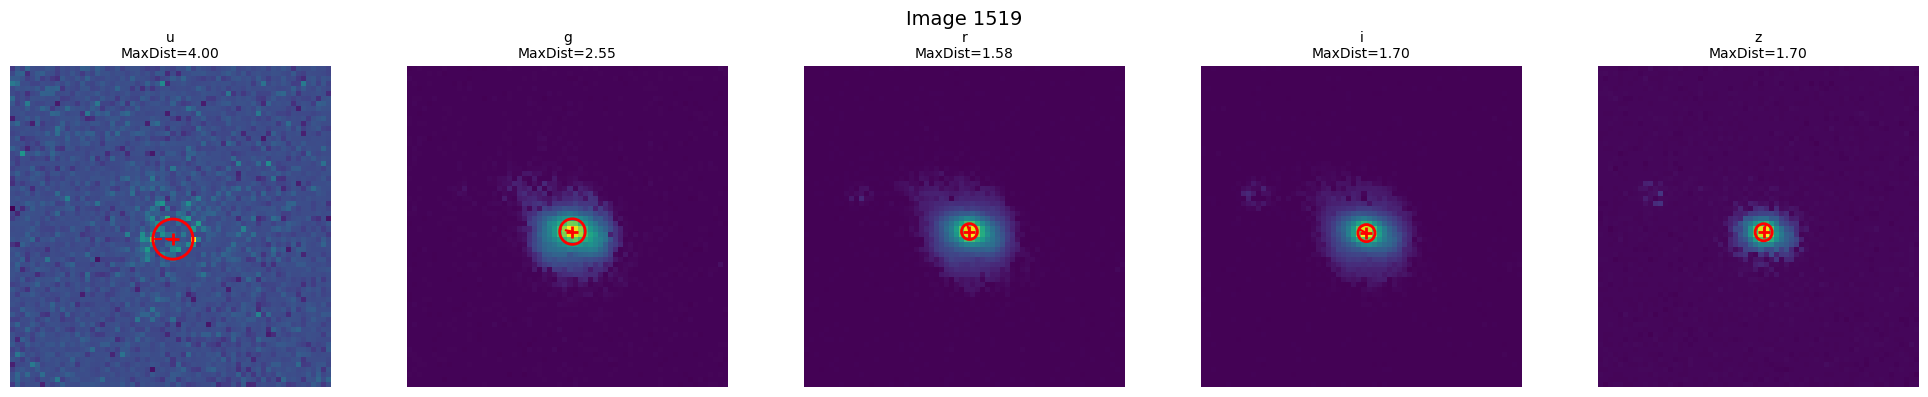

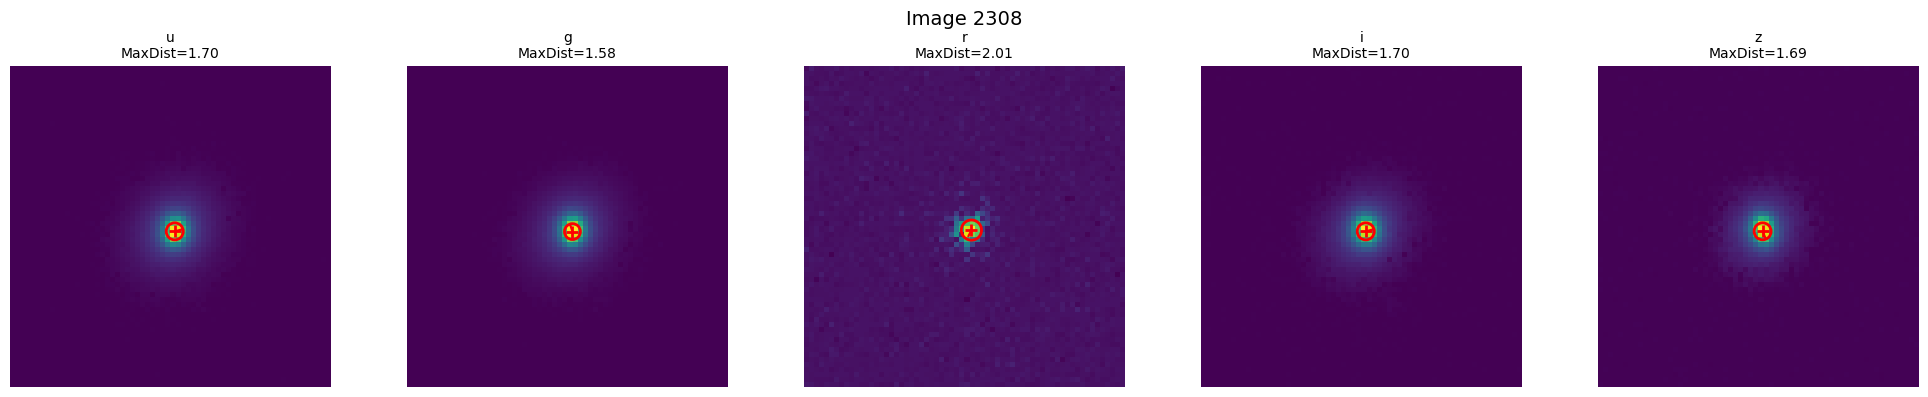

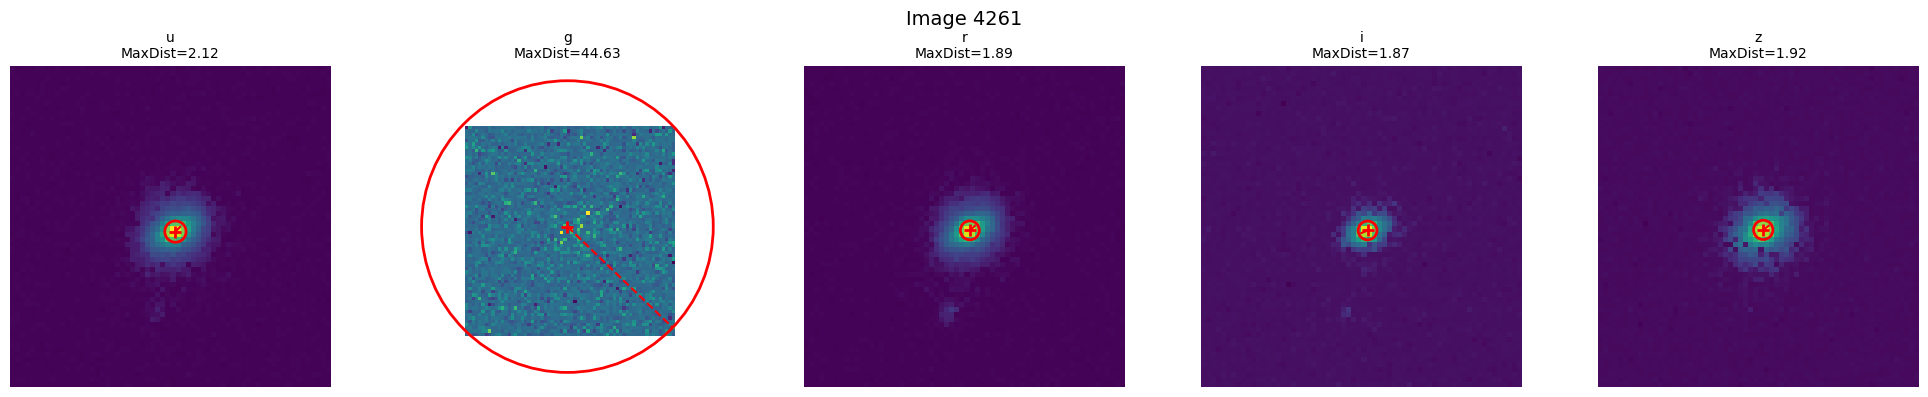

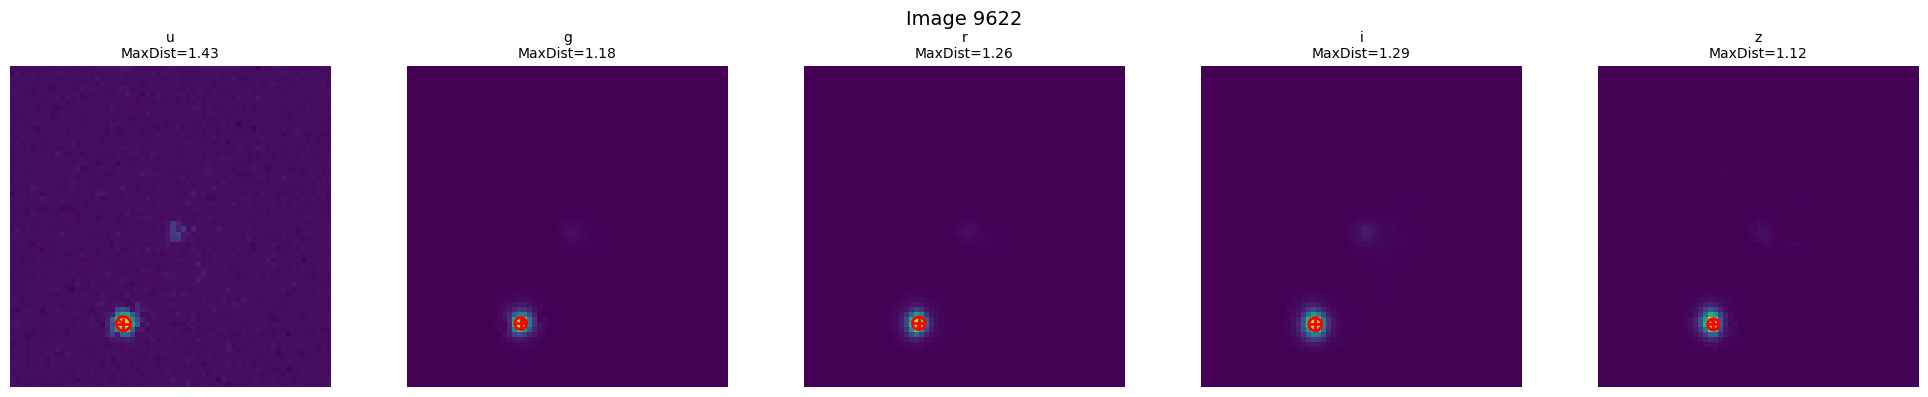

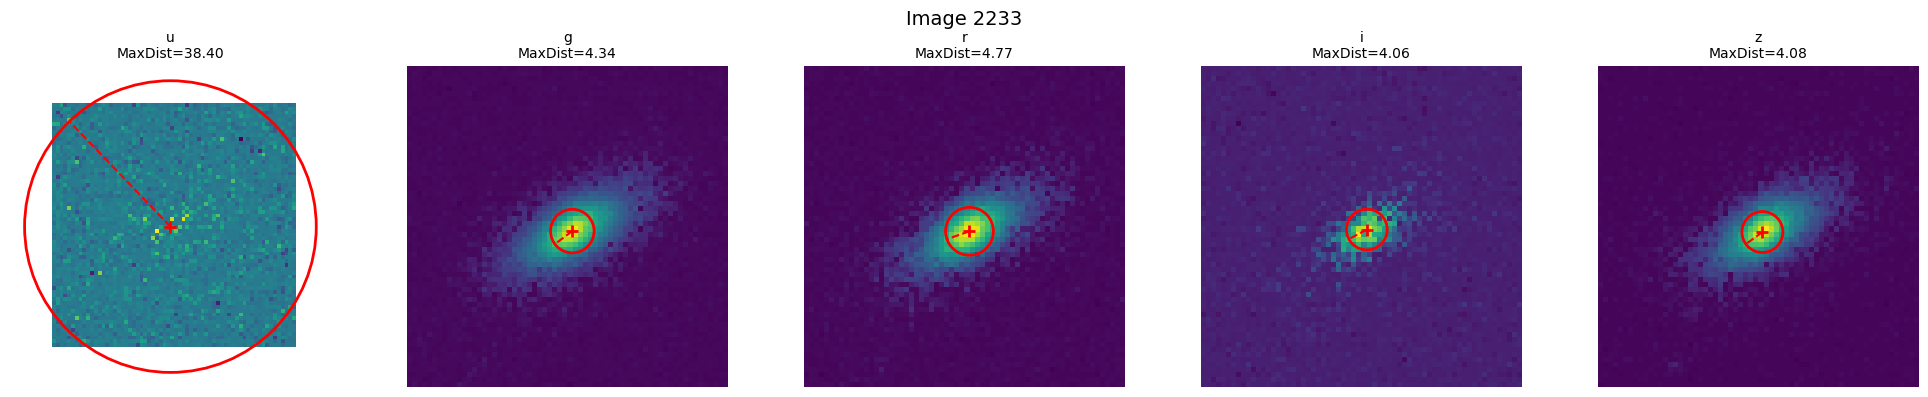

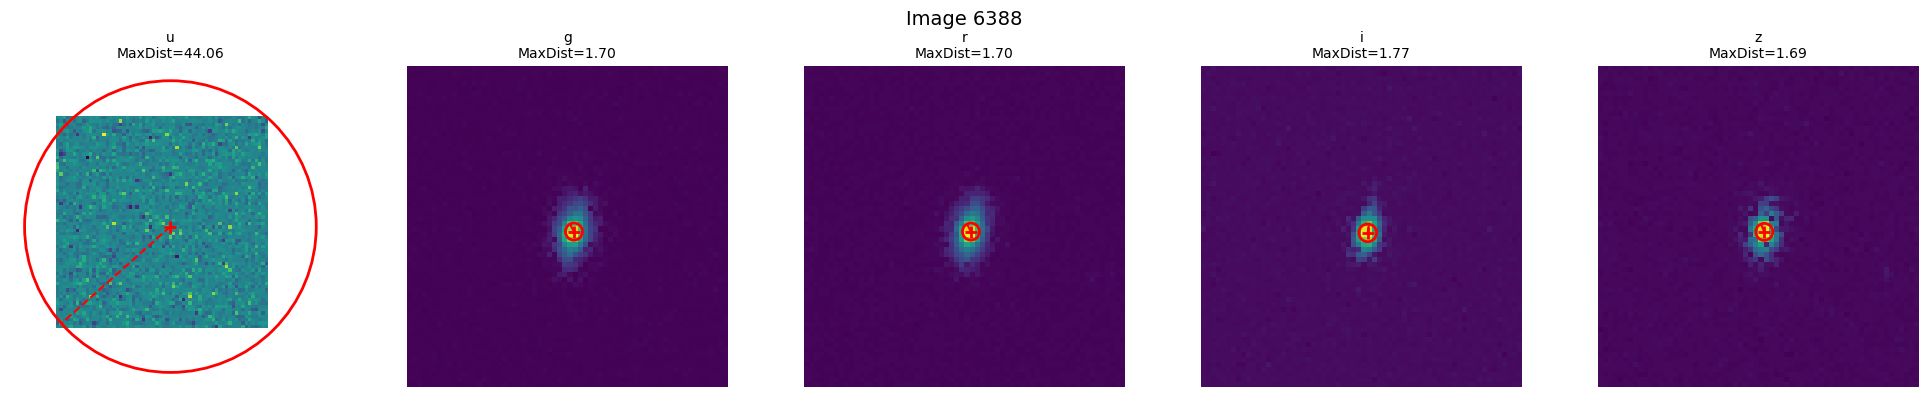

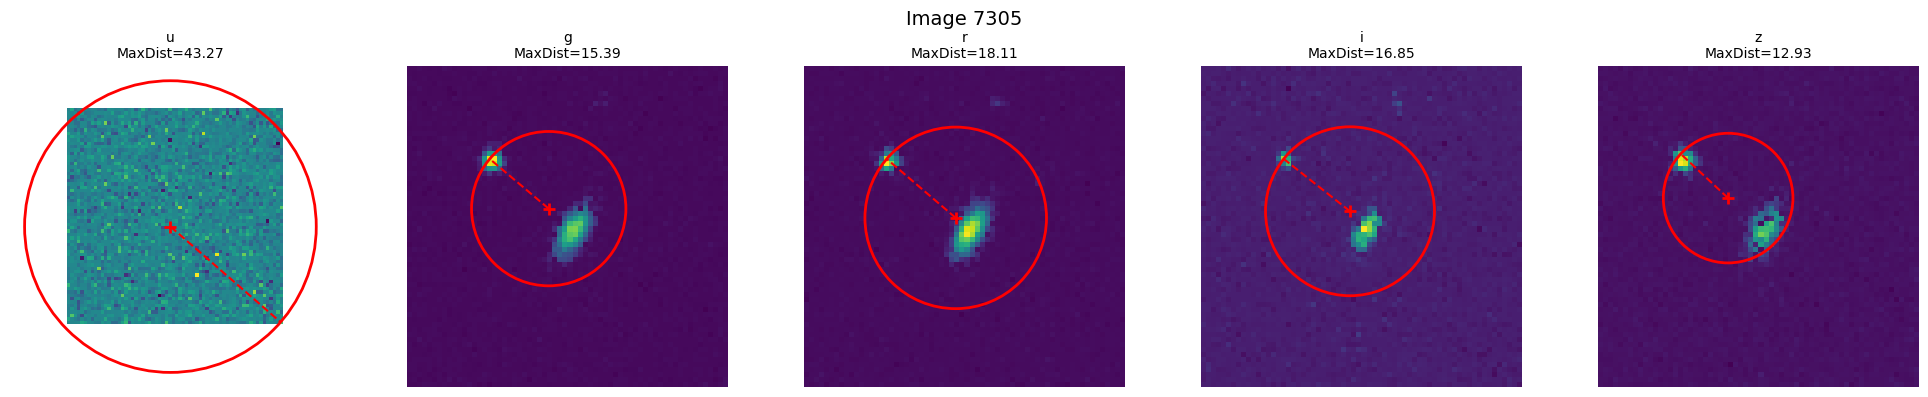

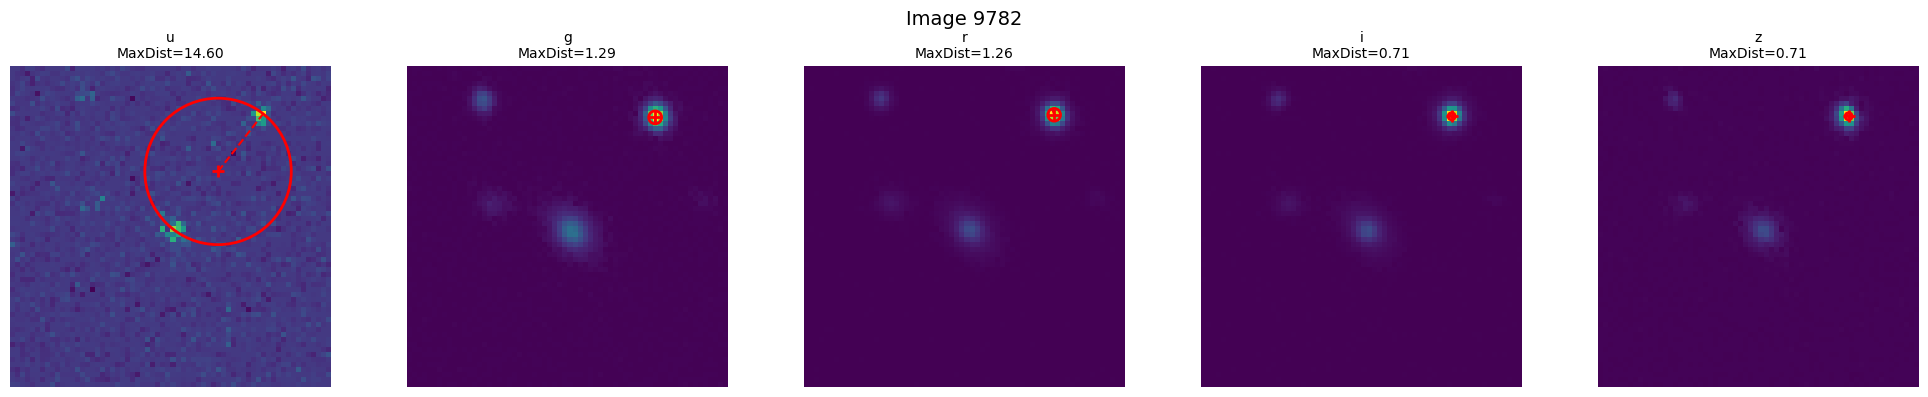

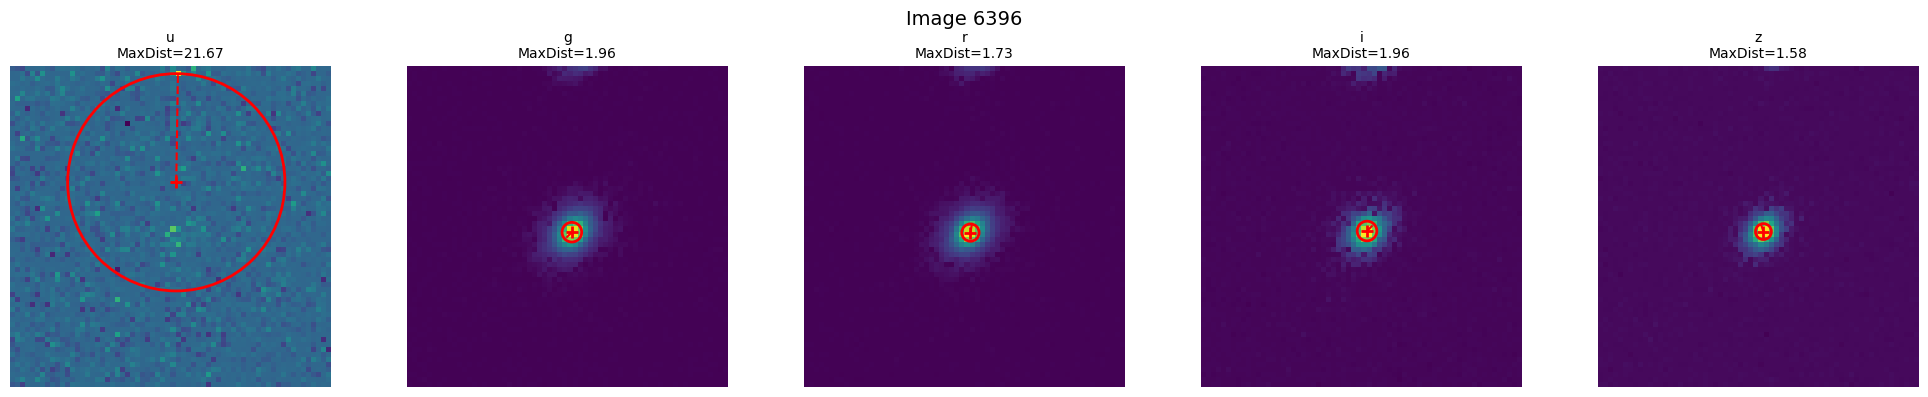

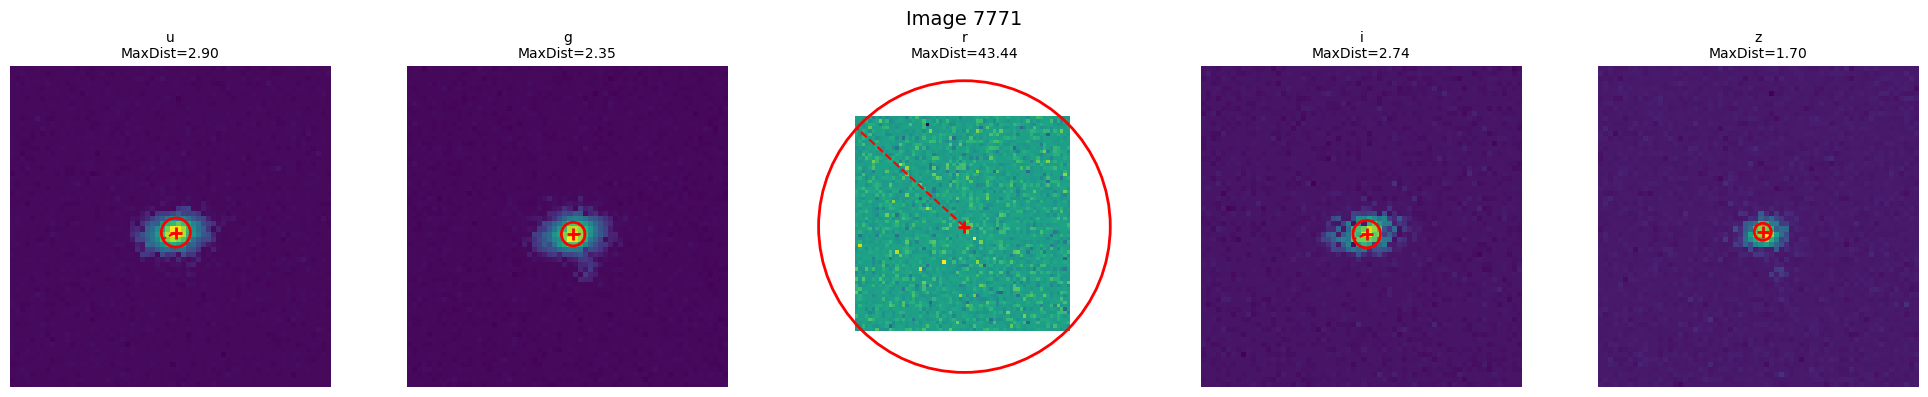

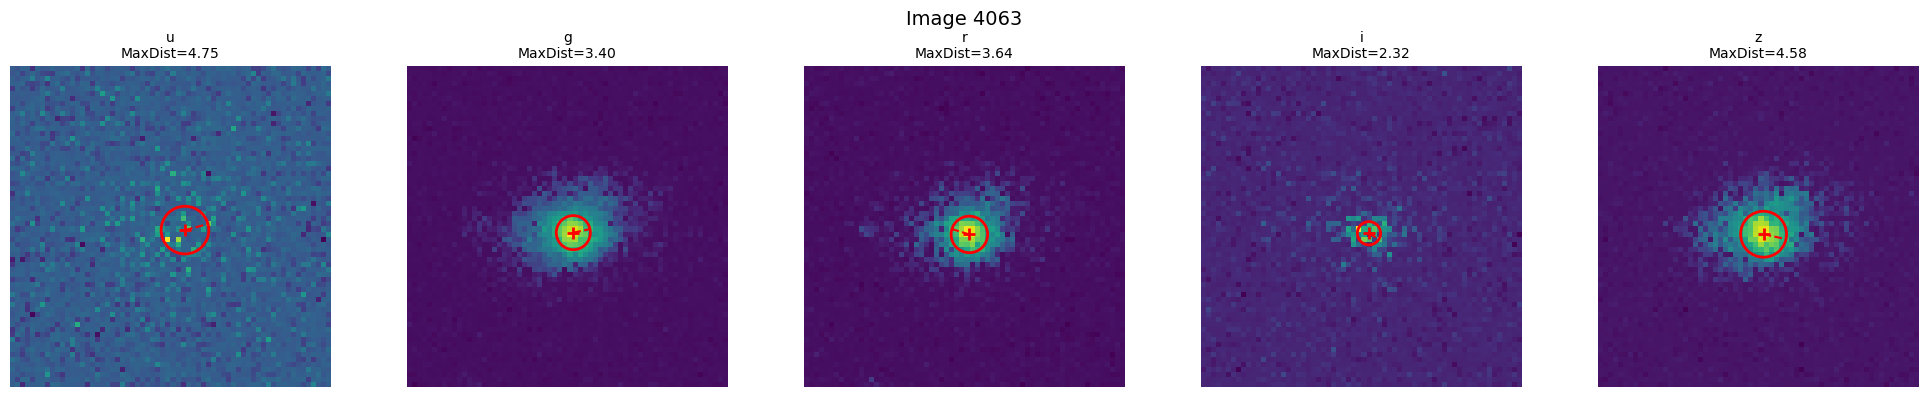

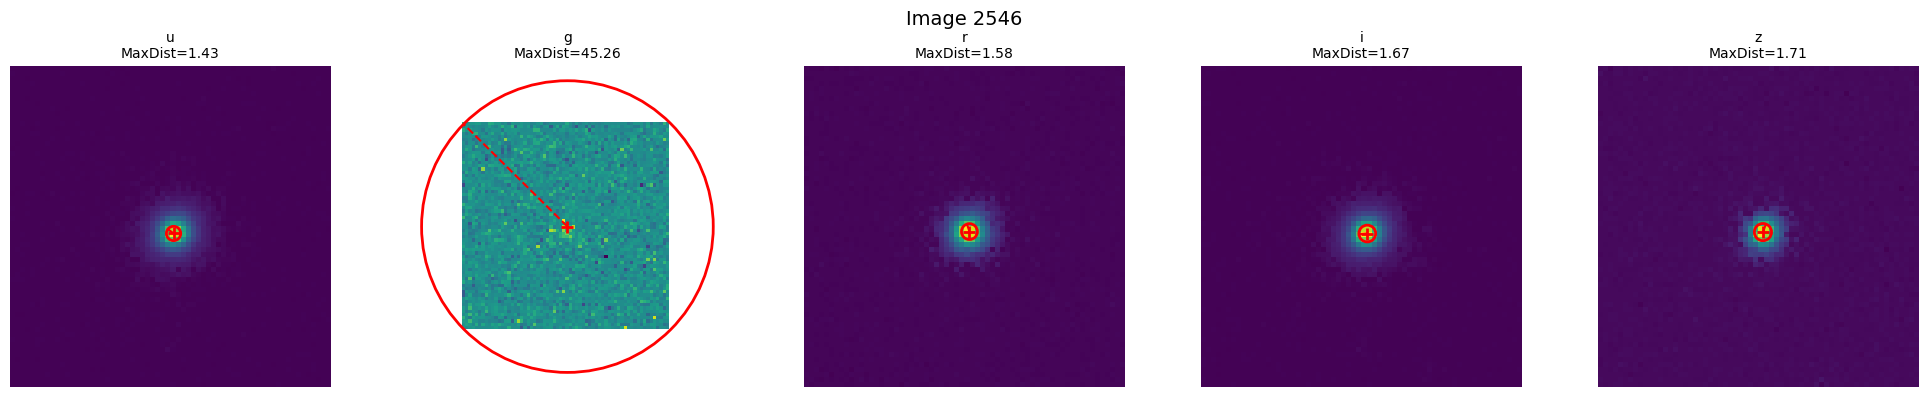

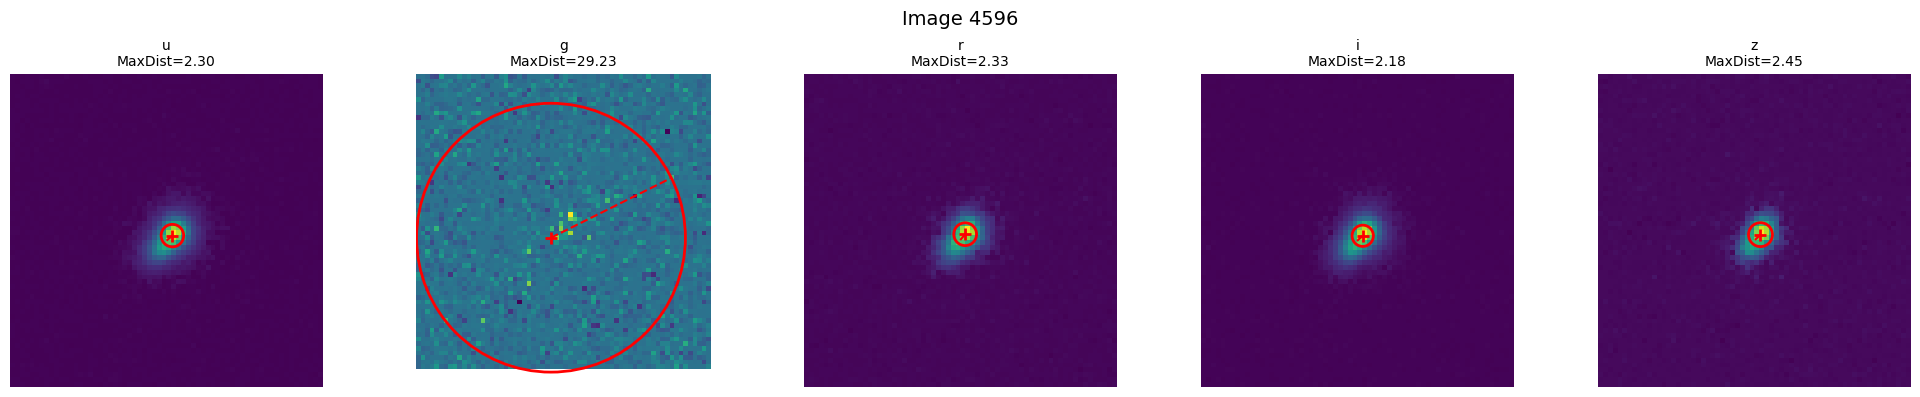

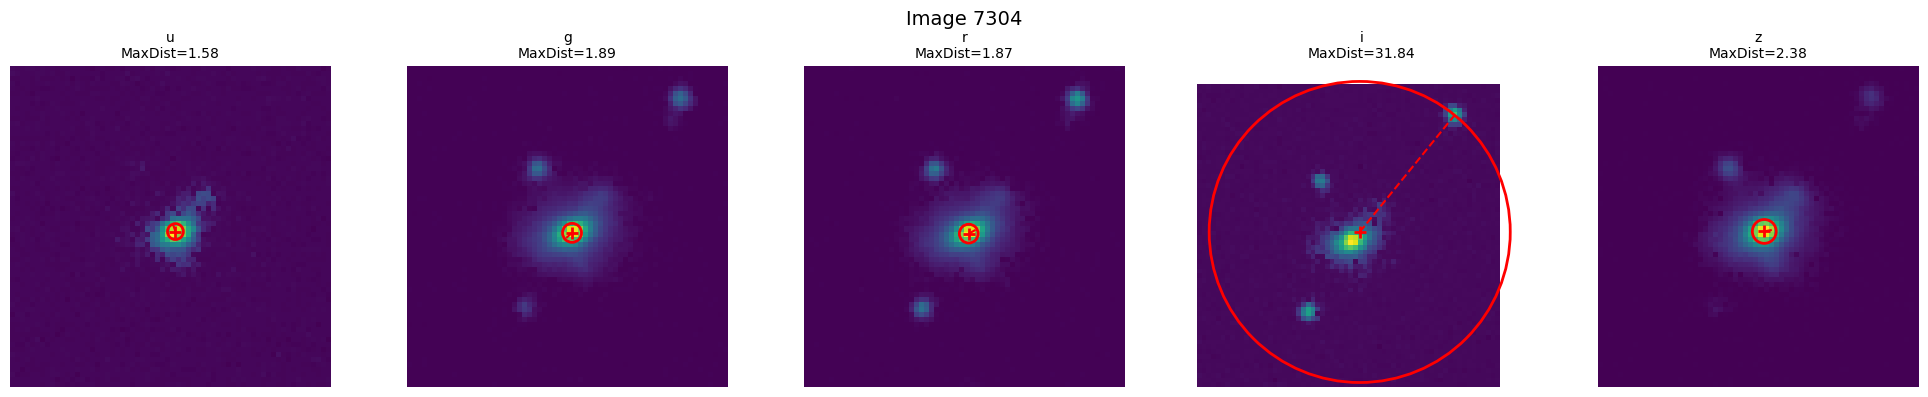

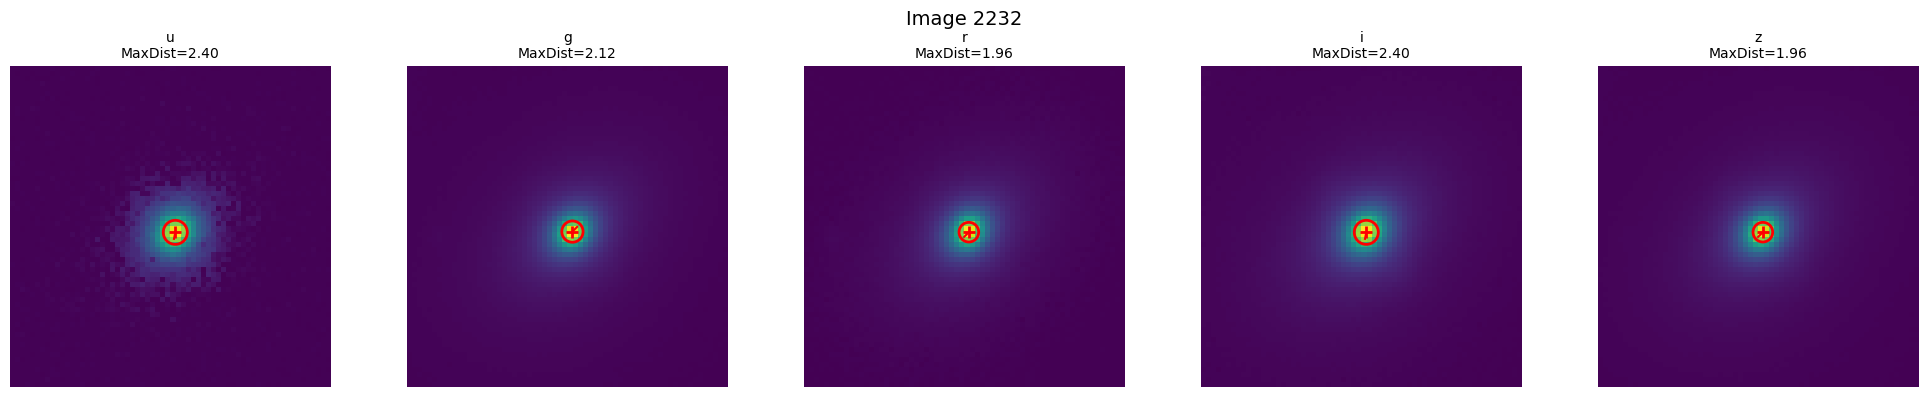

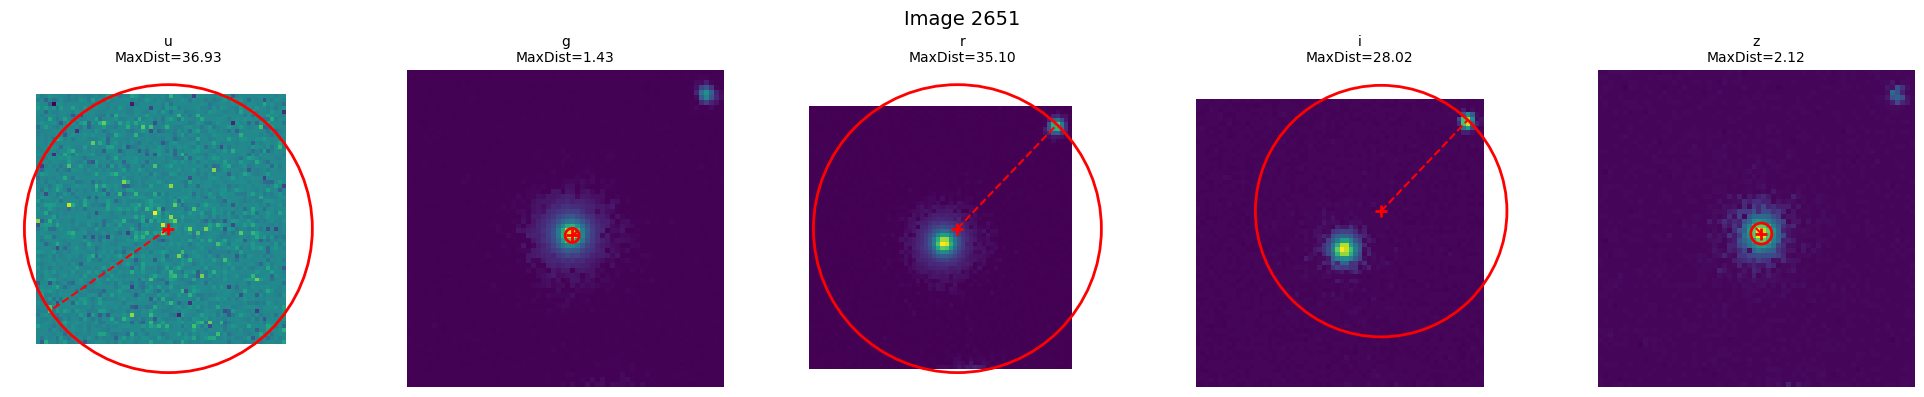

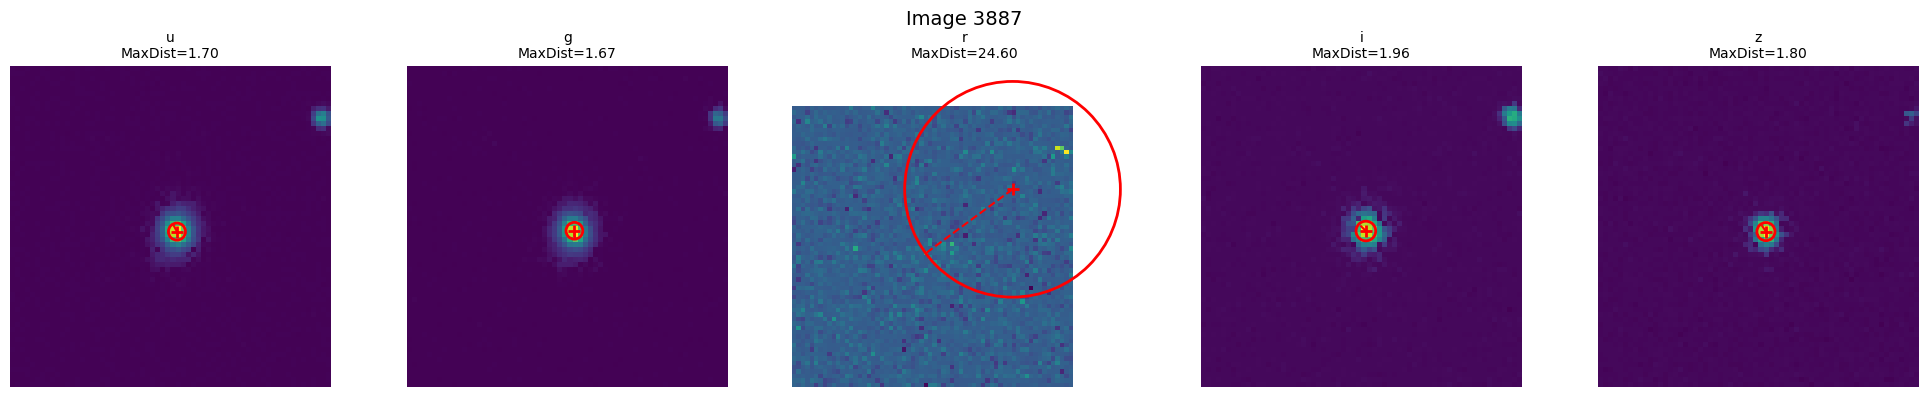

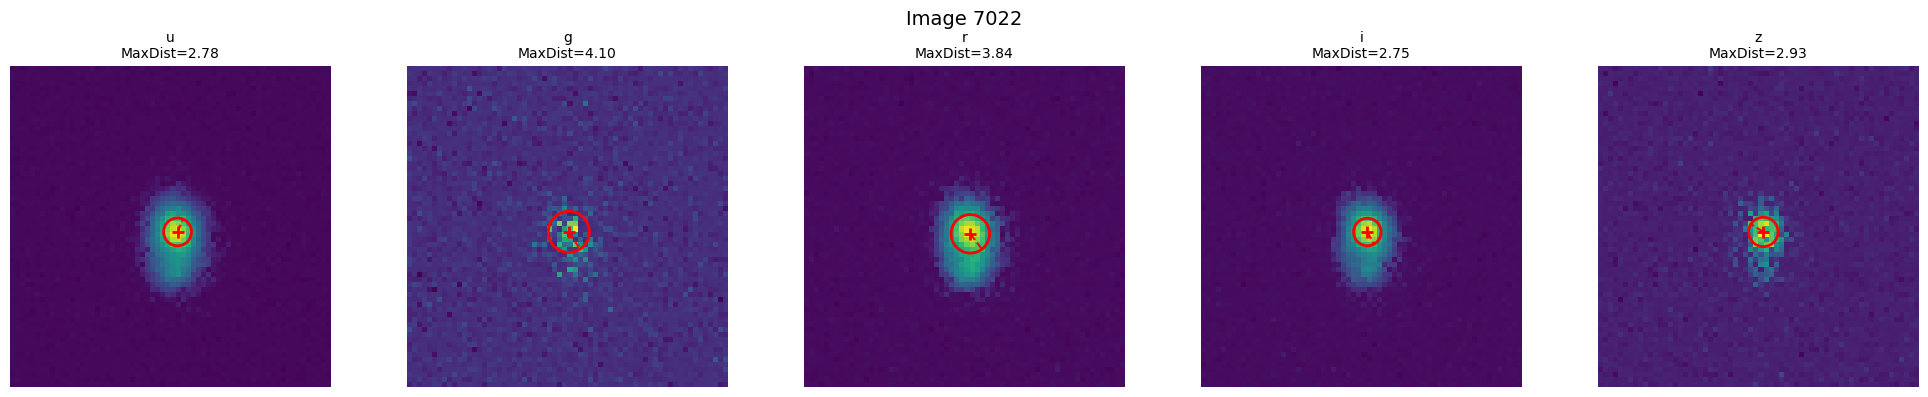

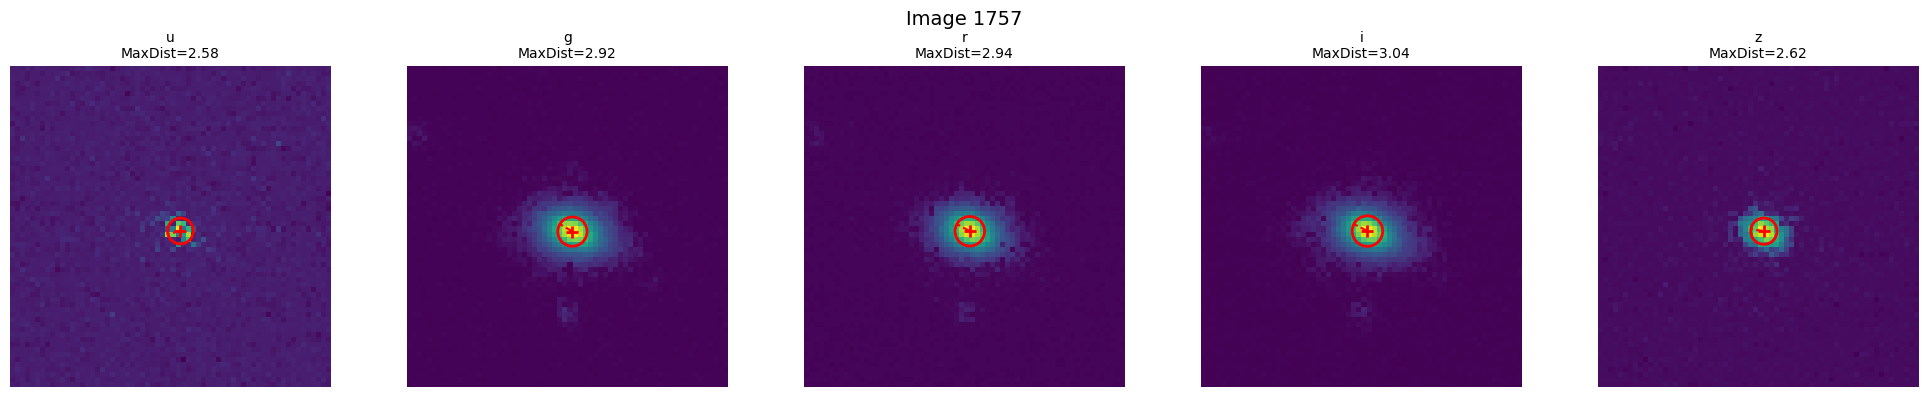

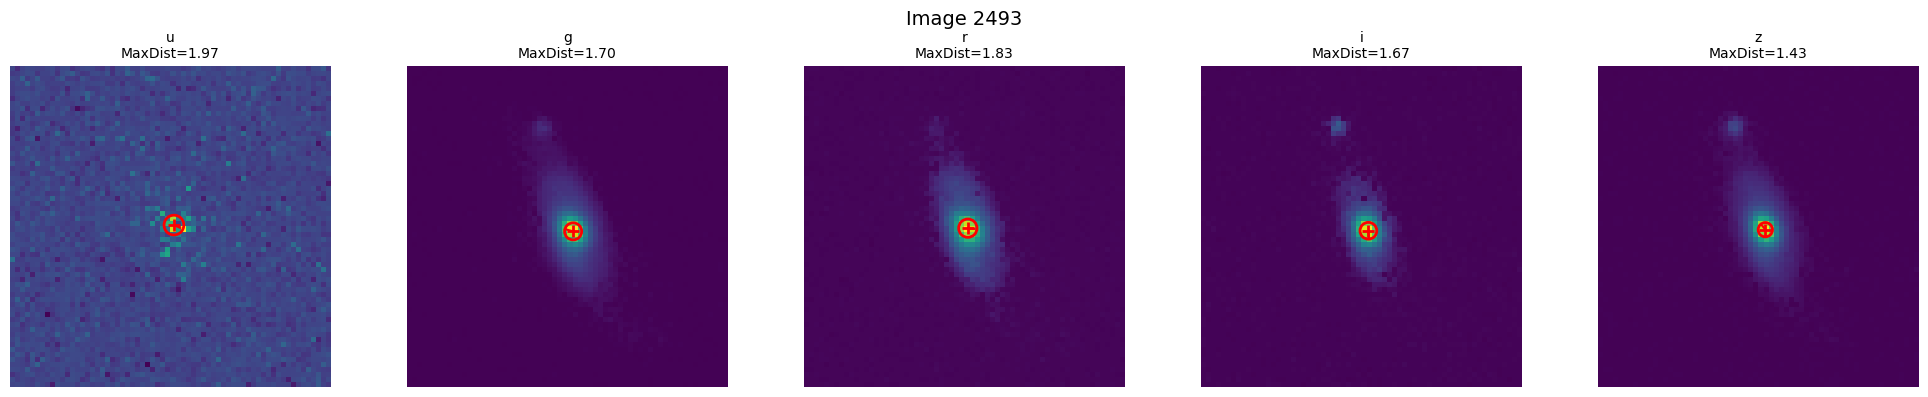

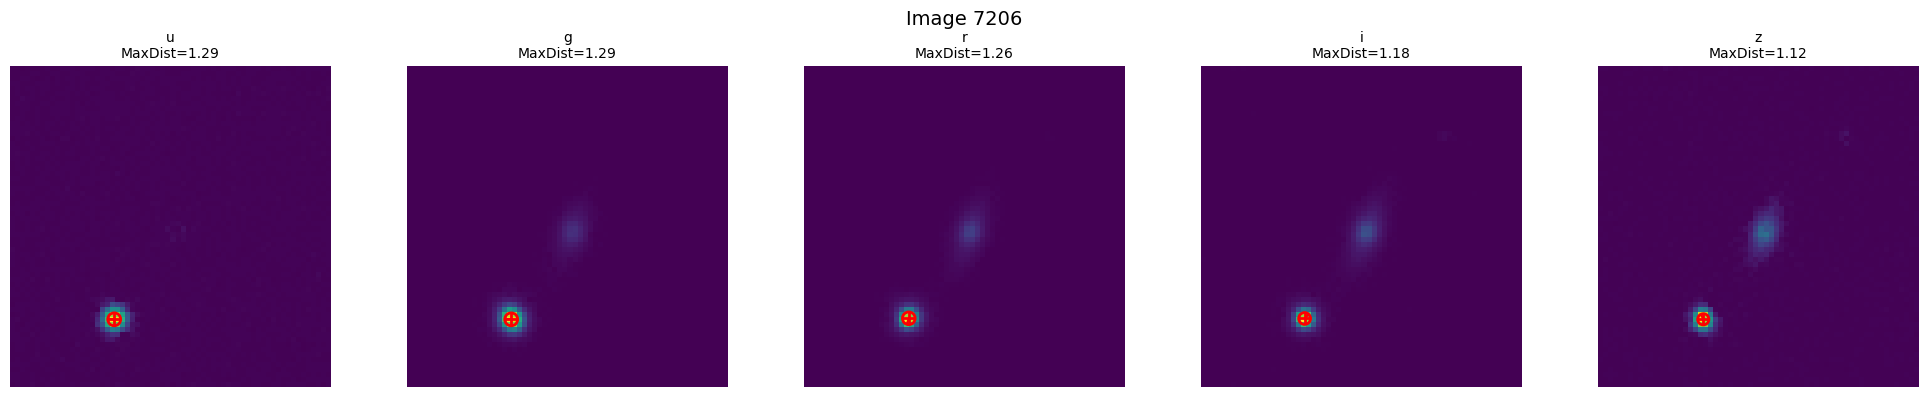

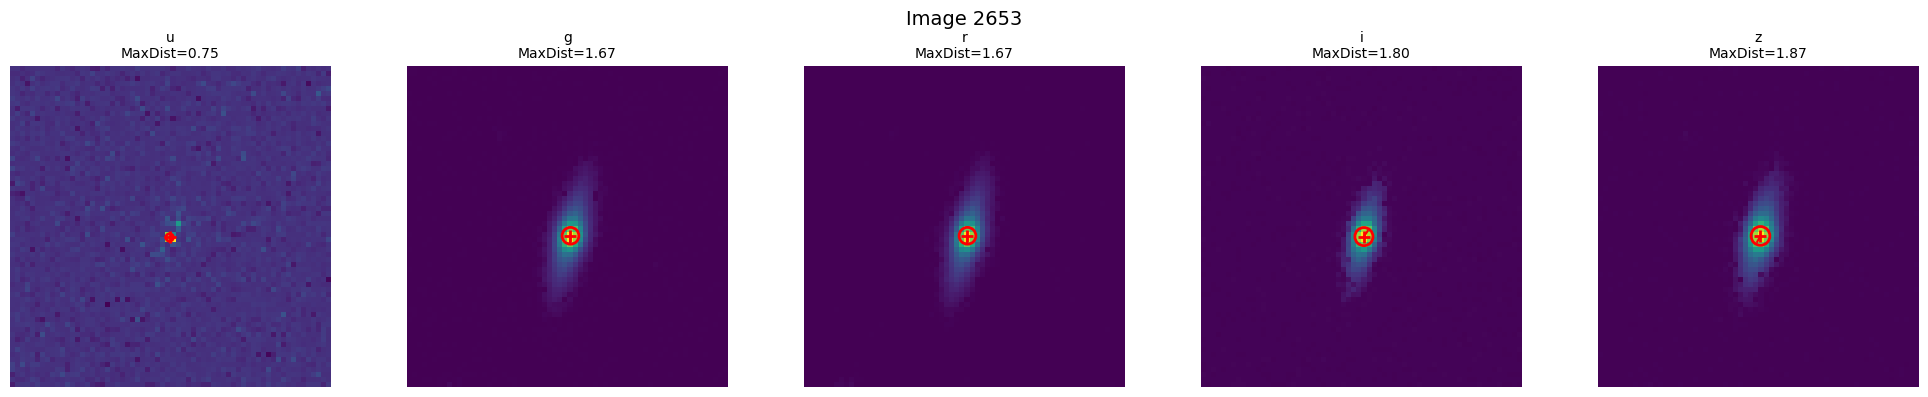

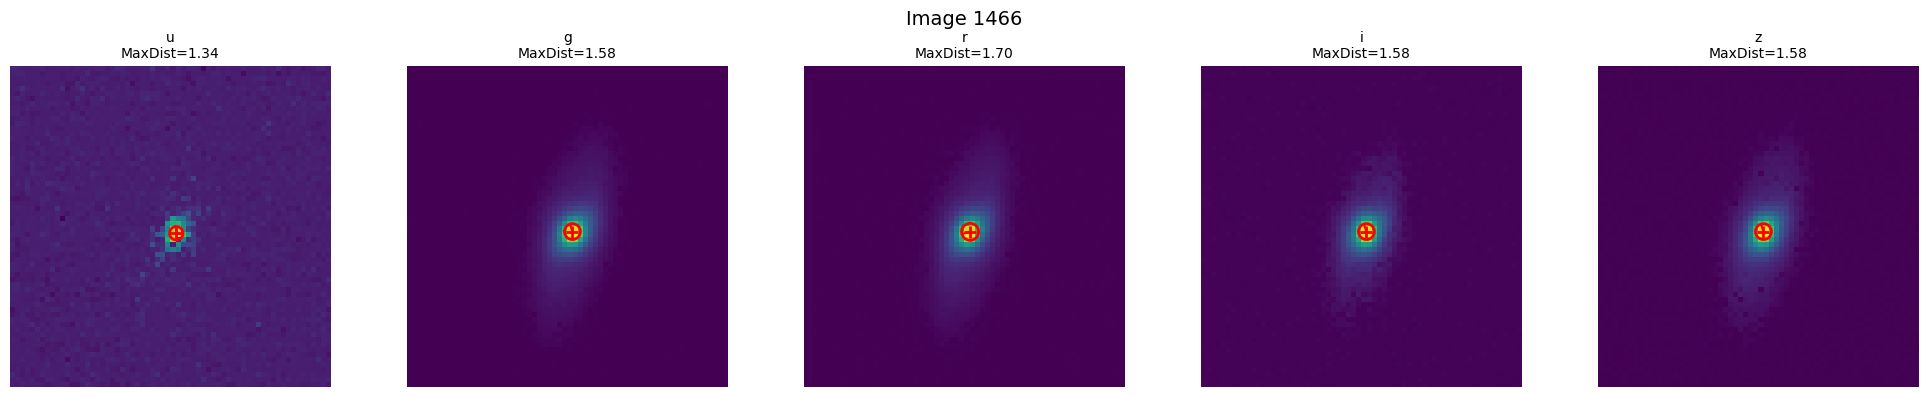

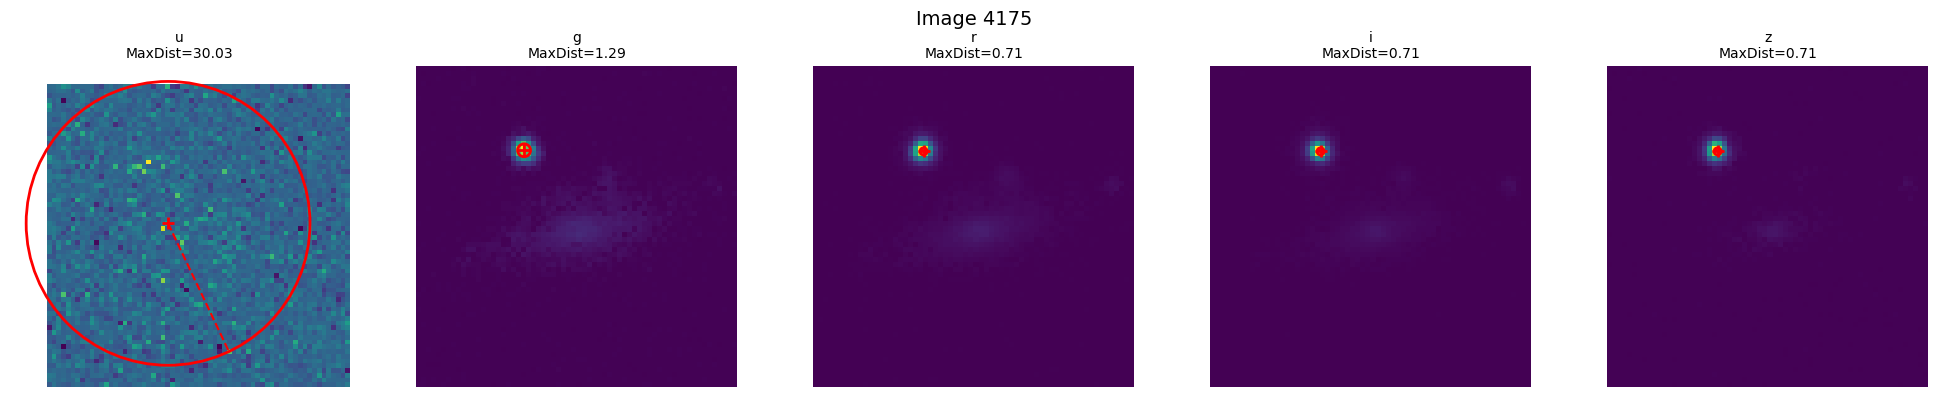

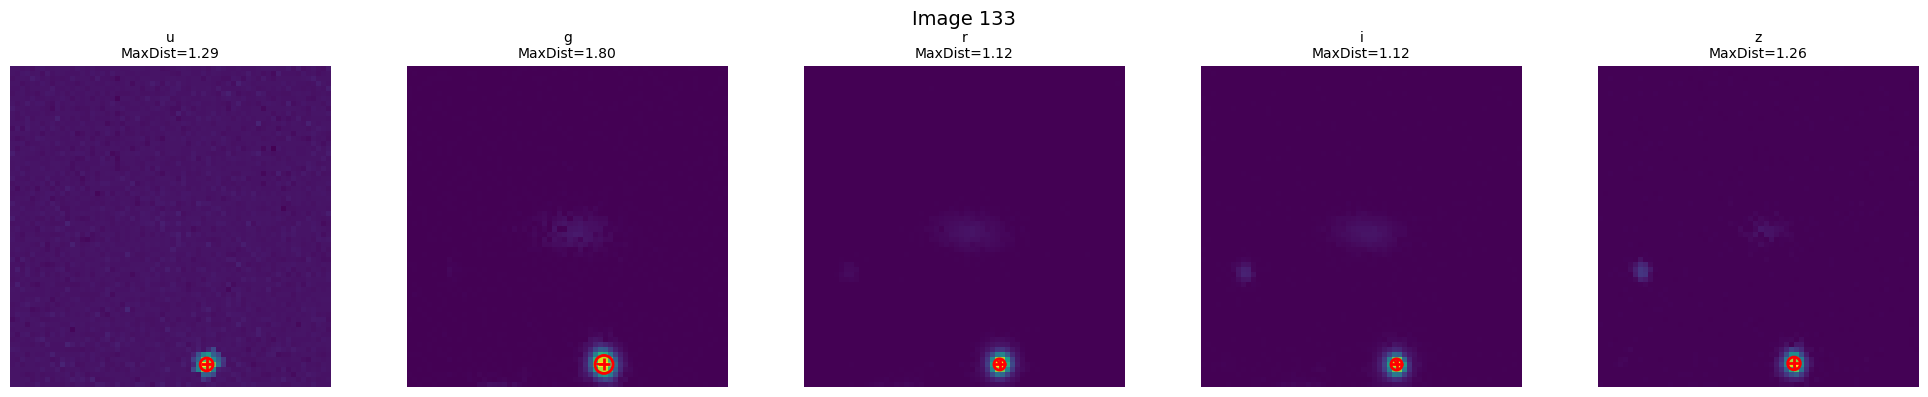

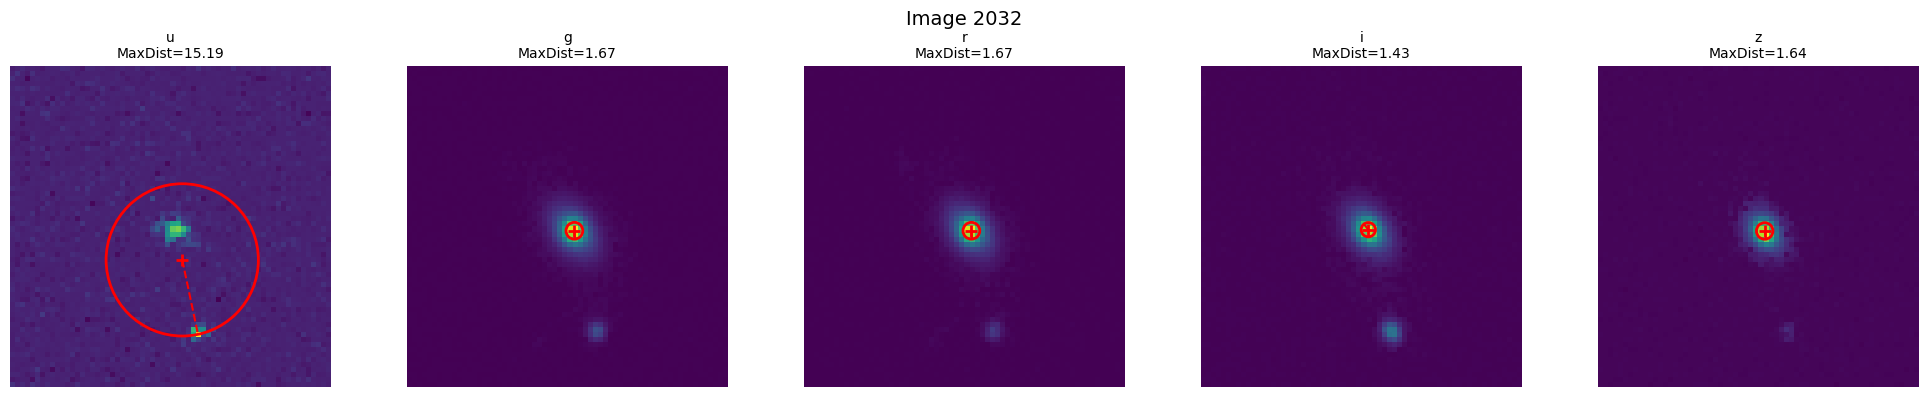

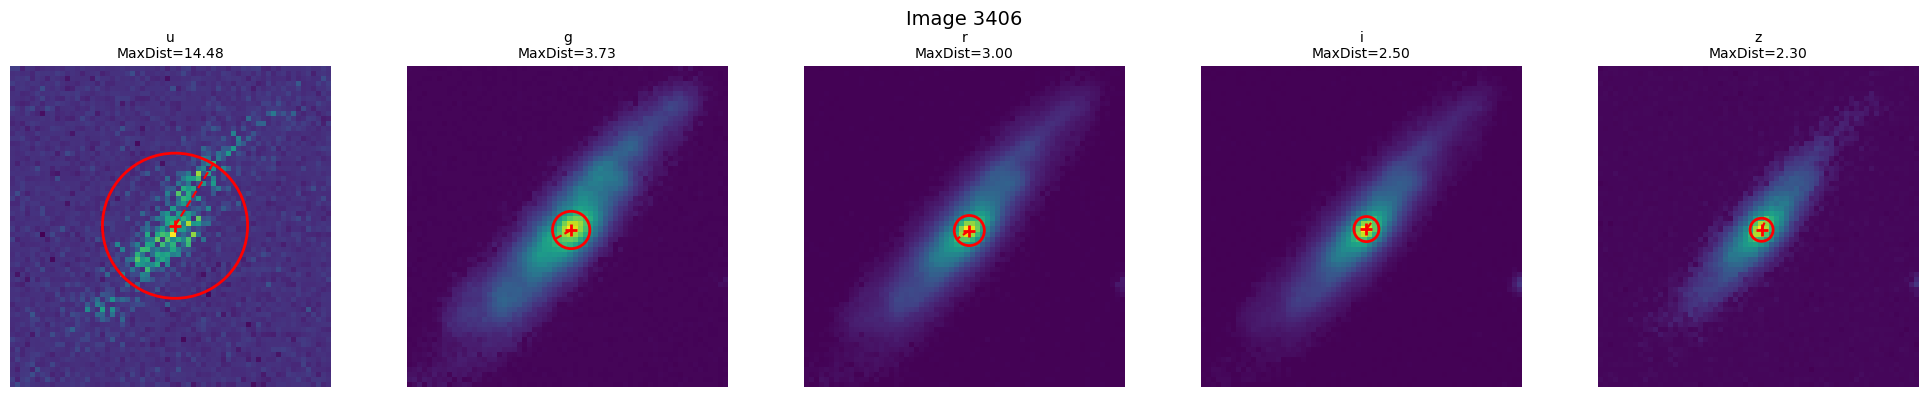

In [24]:
visualize_distance_for_filters(all_images, threshold_fraction=0.3, filters=filters, num_samples=50)